In [6]:
"This notebook is for selection genes that show bimodal distributions in the corresponding processes."

'This notebook is for selection genes that show bimodal distributions in the corresponding processes.'

In [8]:
import scvelo as scv
import pandas as pd 
import numpy as np
from anndata import AnnData
import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.patches as mpatches
import pickle
import os
import leidenalg
from scipy import sparse
from IPython.display import SVG
from sklearn.linear_model import LinearRegression
from scipy import stats,signal
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from filter_dispersion import filter_dispersion
from scipy.sparse import issparse
from scvelo.preprocessing.utils import get_mean_var,materialize_as_ndarray
from sklearn.cluster import MeanShift
from scipy.stats import gaussian_kde, norm
from scipy.signal import find_peaks, peak_prominences

In [9]:
if not os.path.exists('result/'):
    os.makedirs('result/')
result_path='result/'

In [10]:
adata0=scv.read('endocrinogenesis_alpha.h5ad', cache=True)
t_list=['Ngn3 low EP','Ngn3 high EP','Fev+','Alpha']

In [11]:
"selecting the high dispersion genes in the CPT"

'selecting the high dispersion genes in the CPT'

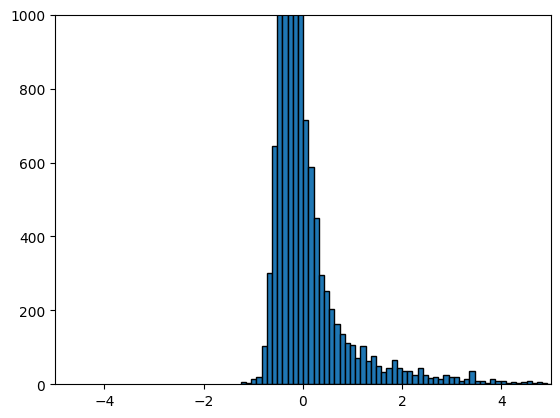

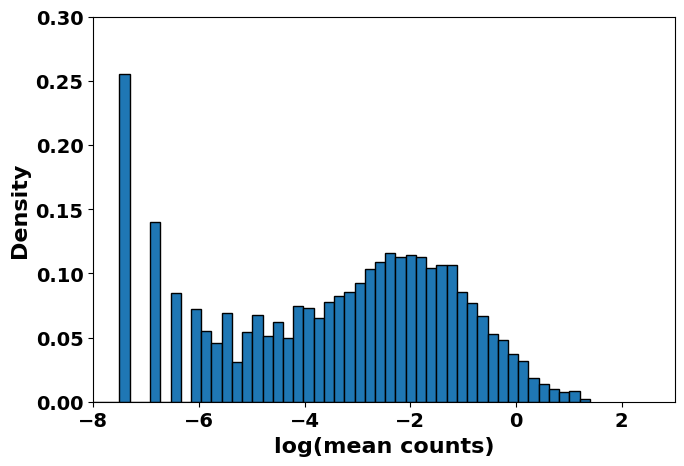

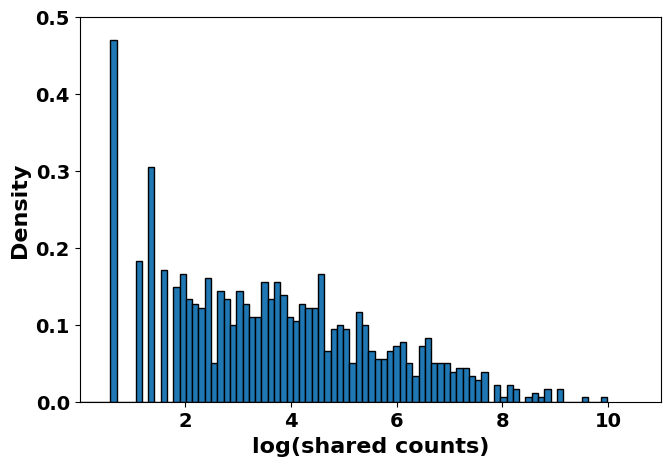

(823,)

In [12]:
adata=adata0.copy()
adata,df,gene_subset=filter_dispersion(adata,n_bins=20,min_disp = 0.5,max_disp = np.inf,min_mean = 0.01,max_mean = 3)

plt.hist(df["dispersion_norm"].values,bins=200,edgecolor='k')
plt.axis([-5,5,0,1000])
plt.show()

plt.figure(figsize=(7.5,5))
plt.hist(np.log(df["mean"].values),bins=150,edgecolor='k',density=True)
plt.axis([-8,3,0,0.3])
plt.xlabel('log(mean counts)',fontsize=16,fontweight='bold')
plt.ylabel('Density',fontsize=16,fontweight='bold')
plt.xticks(np.arange(-8,3,2),fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'EG_mean_counts_distribution.png',dpi=300)
plt.show()

# adata.var.index.values[gene_subset].shape
hv_genes=adata.var.index.values[gene_subset]
adata=adata[:,hv_genes]

#----distribution of shared counts

Xs, Xu = adata.layers["spliced"], adata.layers["unspliced"]
nonzeros = (
    (Xs > 0).multiply(Xu > 0) if issparse(Xs) else (Xs > 0) * (Xu > 0)
            )
X = (
    nonzeros.multiply(Xs) + nonzeros.multiply(Xu)
    if issparse(nonzeros)
                else nonzeros * (Xs + Xu)
            )

# plt.hist(np.sum(X.A,axis=0),bins=100,edgecolor='k')

plt.figure(figsize=(7.5,5))
plt.hist(np.log(np.sum(X.A,axis=0)+1e-6),bins=200,edgecolor='k',density=True)
plt.axis([0,11,0,0.5])
plt.xlabel('log(shared counts)',fontsize=16,fontweight='bold')
plt.ylabel('Density',fontsize=16,fontweight='bold')
plt.xticks(np.arange(2,12,2),fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'EG_shared_counts_distribution.png',dpi=300)
plt.show()

np.where(np.log(np.sum(X.A,axis=0))>2)[0].shape

In [ ]:
adata=adata0[:,hv_genes]
scv.pp.filter_and_normalize(adata,min_shared_counts=10)


print(adata.X.shape)
scv.pp.neighbors(adata, n_neighbors=30)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=30)

scv.tl.umap(adata)
# scv.tl.recover_dynamics(adata)

scv.tl.velocity(adata,mode='stochastic',perc=[5, 95])

scv.tl.velocity_graph(adata,xkey='Ms')

In [ ]:
"selecting genes that can be binarized"

In [9]:
gene_arr=adata.var.index.values

In [10]:
from critical_bandwidth import critical_bandwidth,critical_bandwidth_m_modes

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
def best_split(data, I=(-np.inf, np.inf)):
    '''With bimodal data, finding split at lowest density.'''
    h_crit = critical_bandwidth_m_modes(data, 2, I)
    kde = KernelDensity(kernel='gaussian', bandwidth=h_crit).fit(data.reshape(-1, 1))
    x = np.linspace(max(np.min(data), I[0]), min(np.max(data), I[1]), 200)
    y = np.exp(kde.score_samples(x.reshape(-1, 1)))
    modes = argrelextrema(np.hstack([[0], y, [0]]), np.greater)[0]
    ind_min=[]
    if len(modes)>=2: 
        for i in range(len(modes)-1):
            if len(modes[i]-1 + argrelextrema(y[(modes[i]-1):(modes[i+1]-1)], np.less)[0])>0:
                ind_min.append(modes[i]-1 + argrelextrema(y[(modes[i]-1):(modes[i+1]-1)], np.less)[0][0])
#     else:
#         if len(modes[0]-1 + argrelextrema(y[(modes[0]-1):(modes[1]-1)], np.less)[0])>0:
#             ind_min = modes[0]-1 + argrelextrema(y[(modes[0]-1):(modes[1]-1)], np.less)[0]
#     print(ind_min)
    return x[ind_min]

0


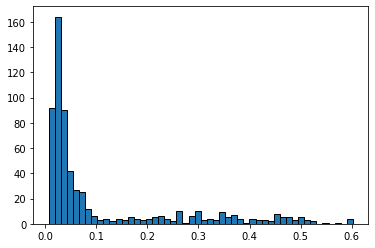

1


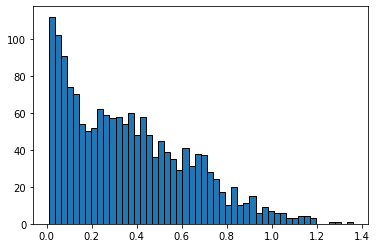

2


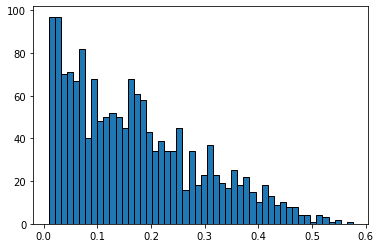

3


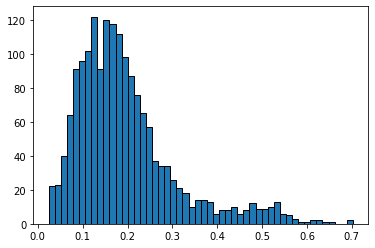

4


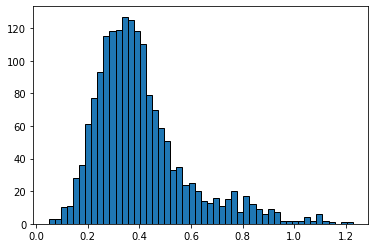

5


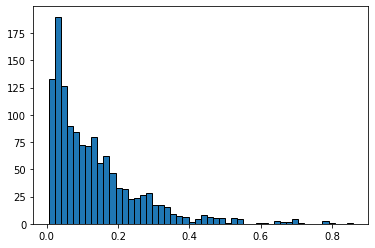

6


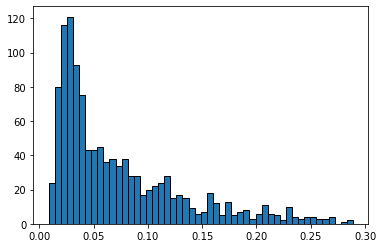

7


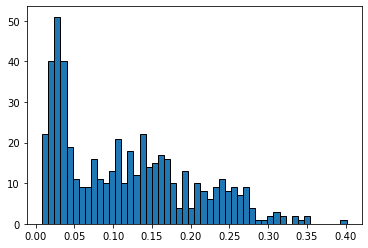

8


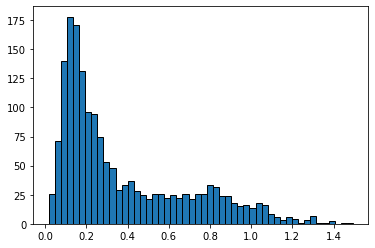

9


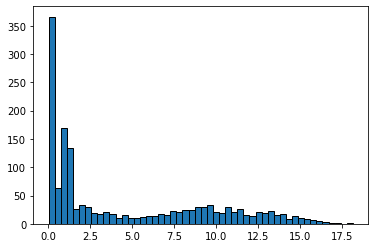

10


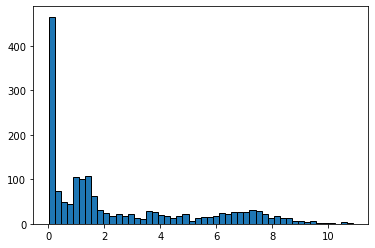

11


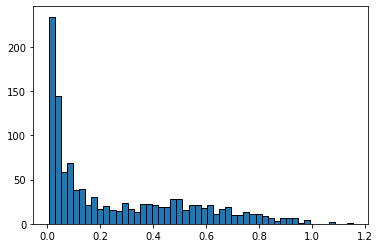

12


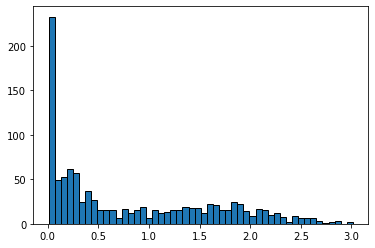

13


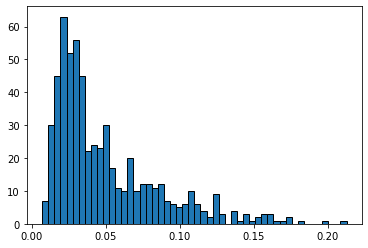

14


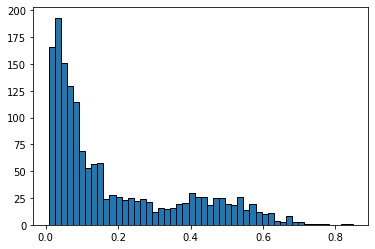

15


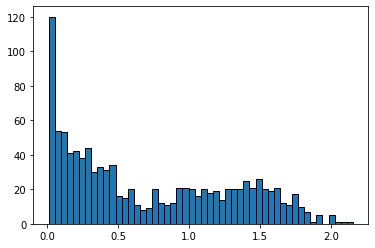

16


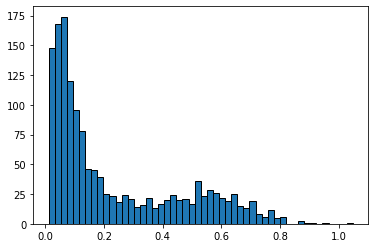

17


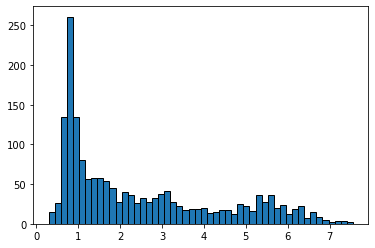

18


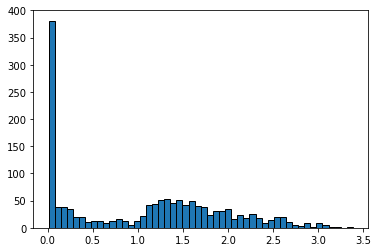

19


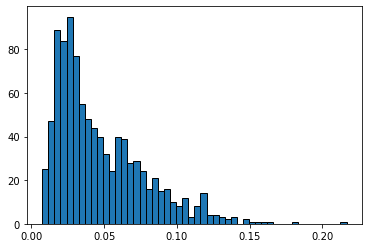

20


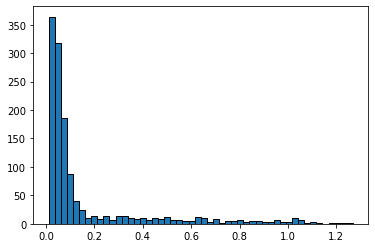

21


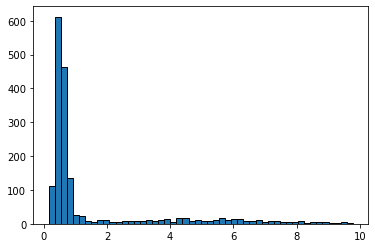

22


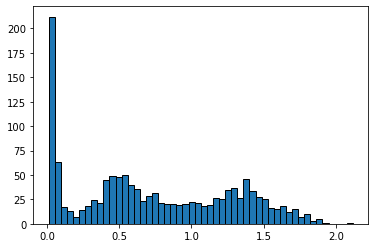

23


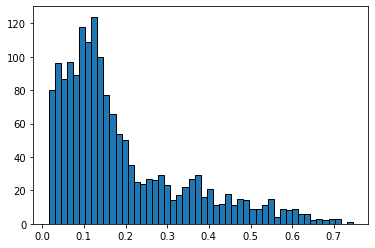

24


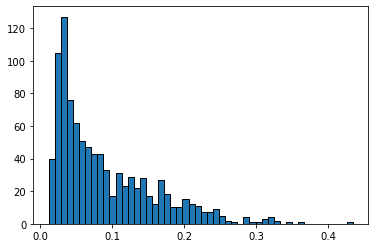

25


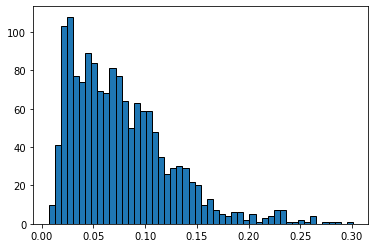

26


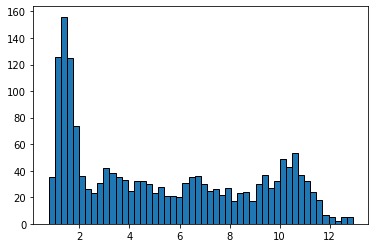

27


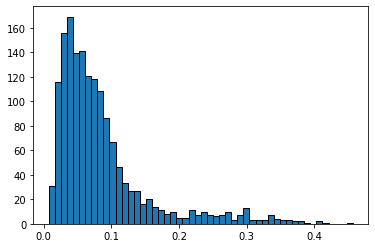

28


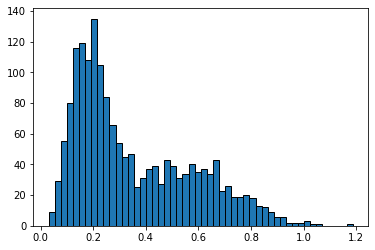

29


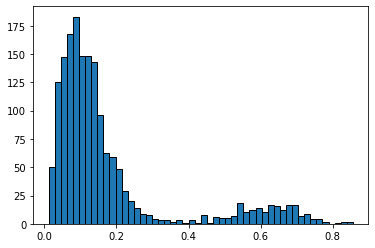

30


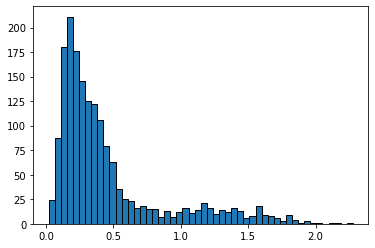

31


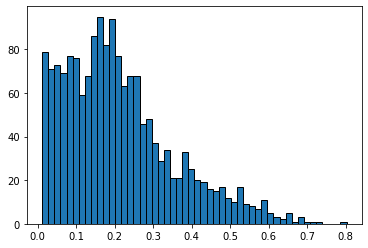

32


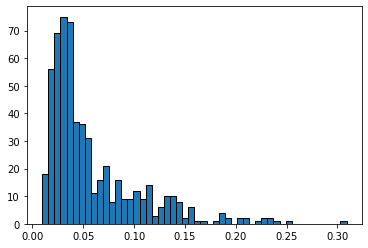

33


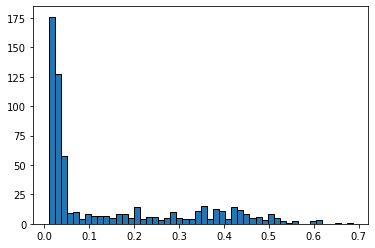

34


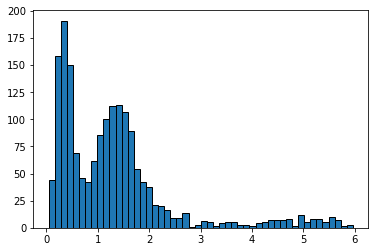

35


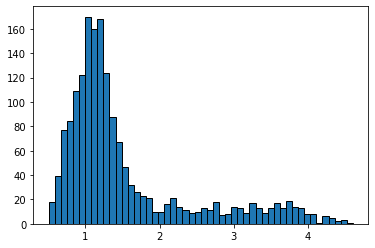

36


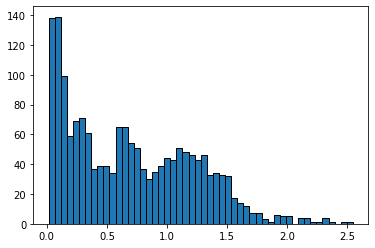

37


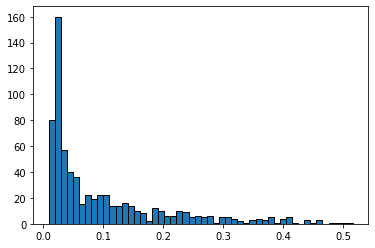

38


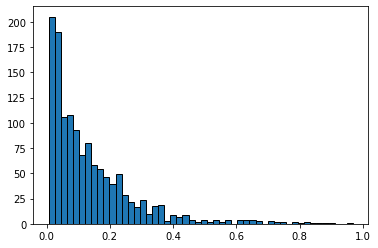

39


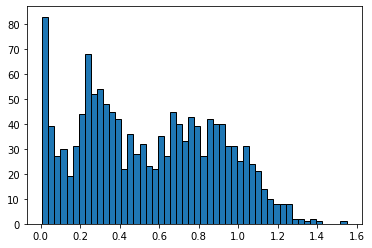

40


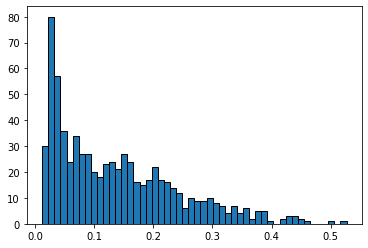

41


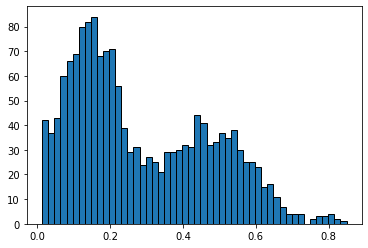

42


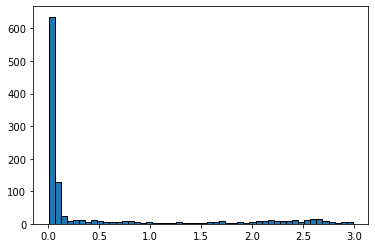

43


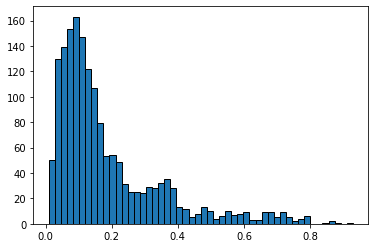

44


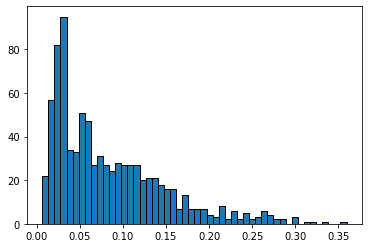

45


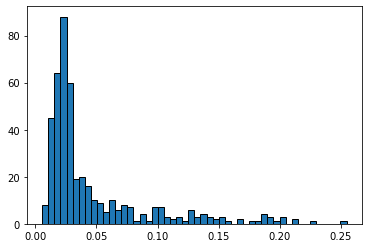

46


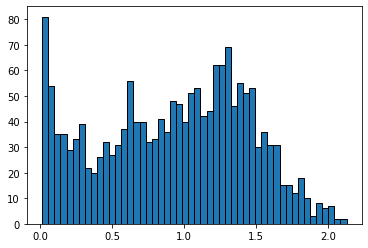

47


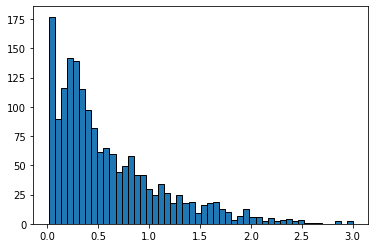

48


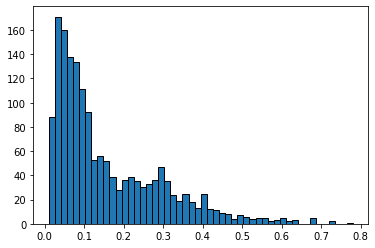

49


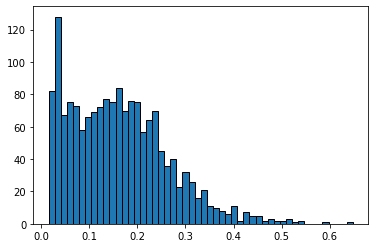

50


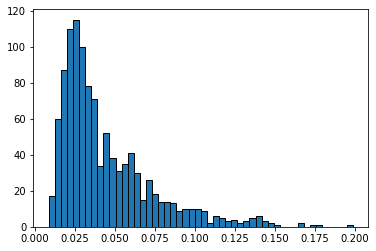

51


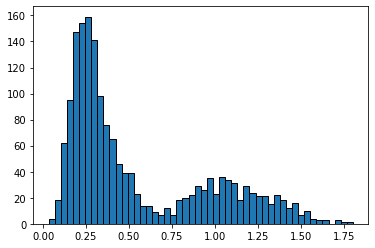

52


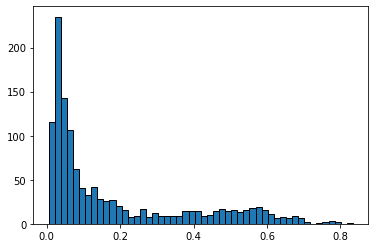

53


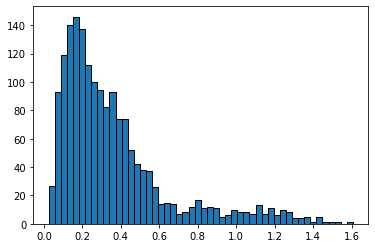

54


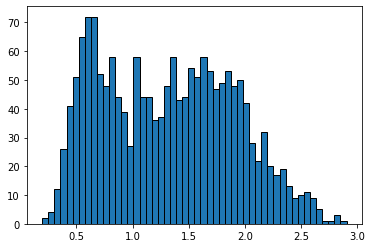

55


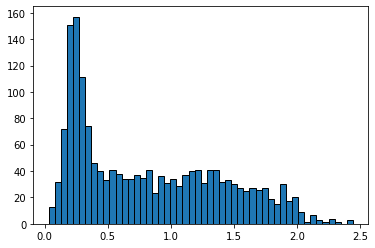

56


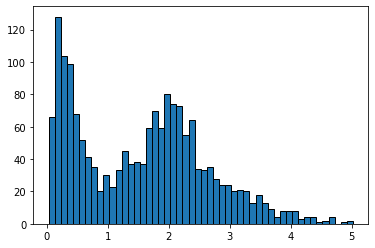

57


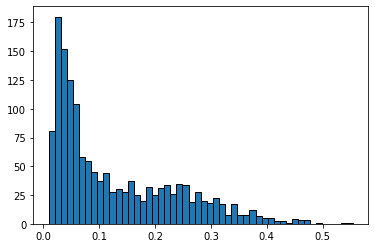

58


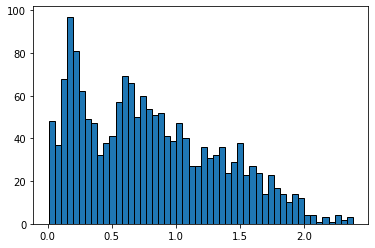

59


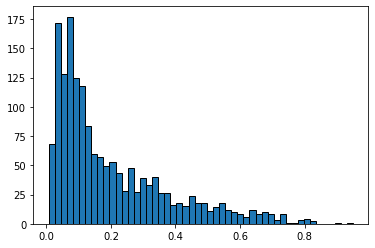

60


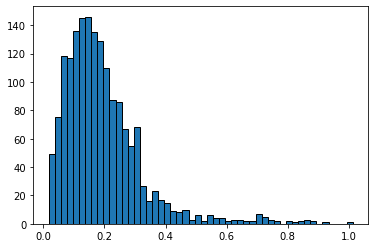

61


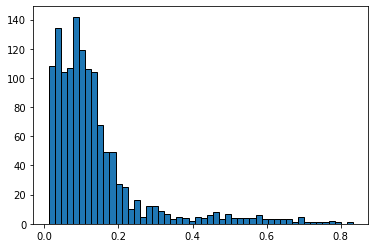

62


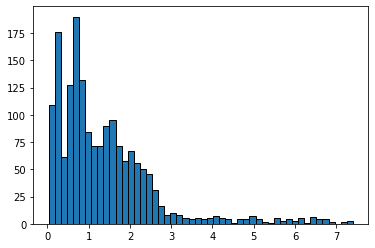

63


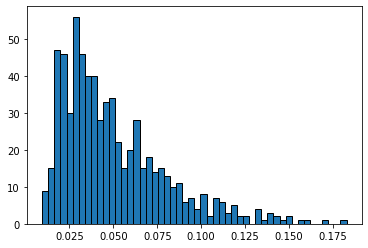

64


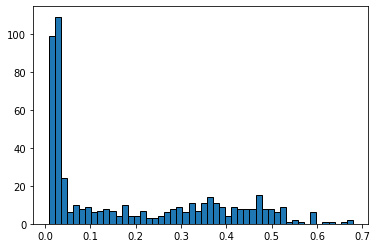

65


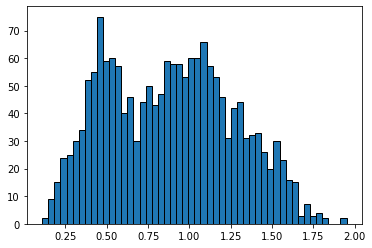

66


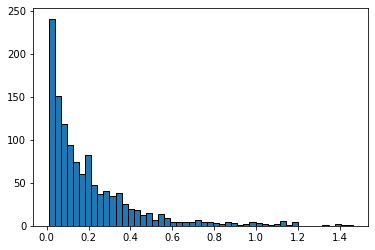

67


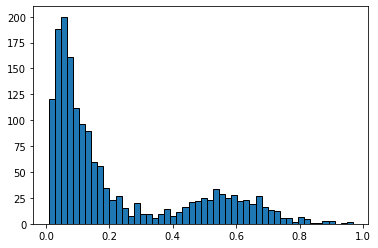

68


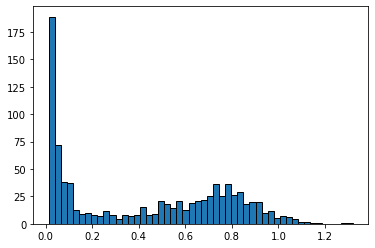

69


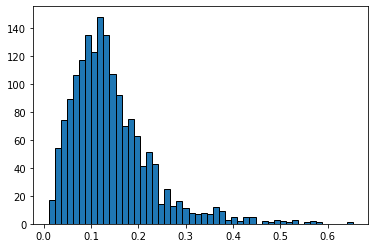

70


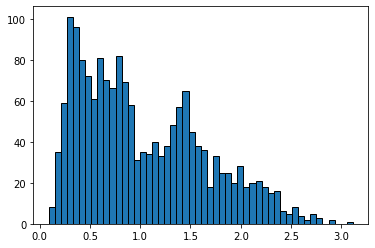

71


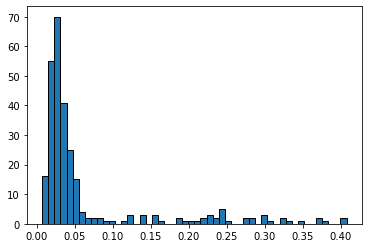

72


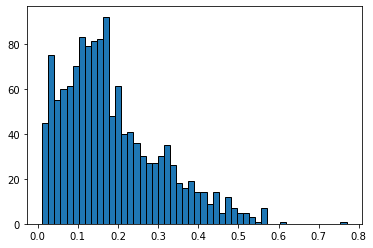

73


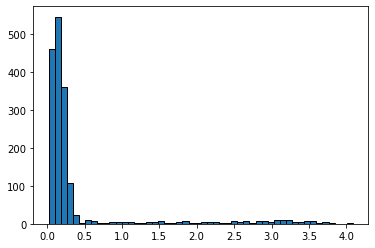

74


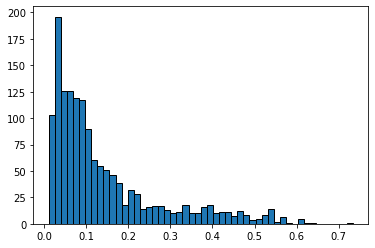

75


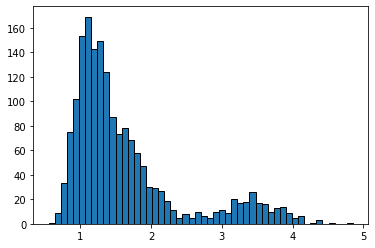

76


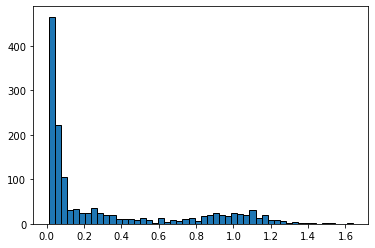

77


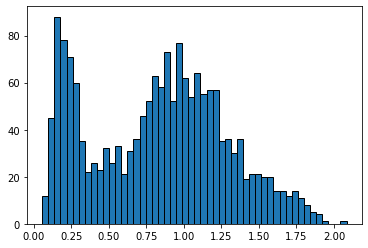

78


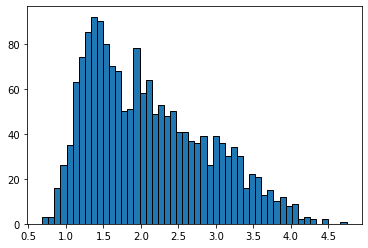

79


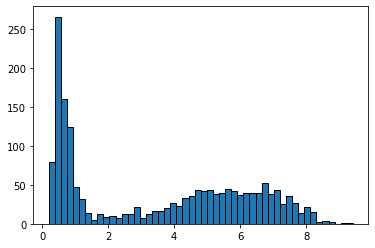

80


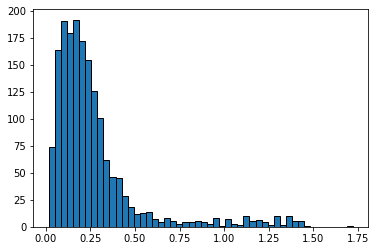

81


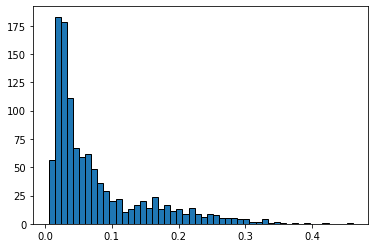

82


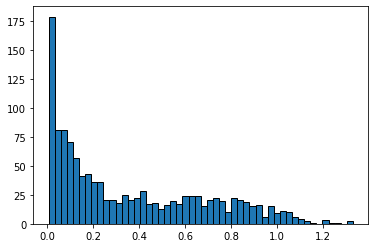

83


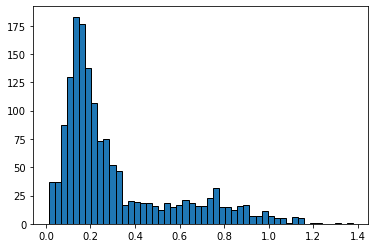

84


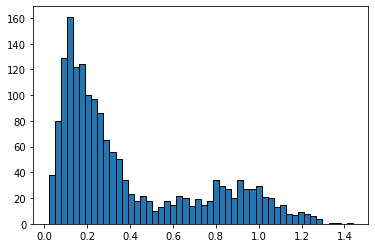

85


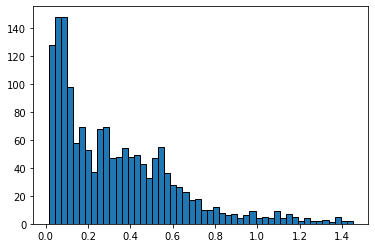

86


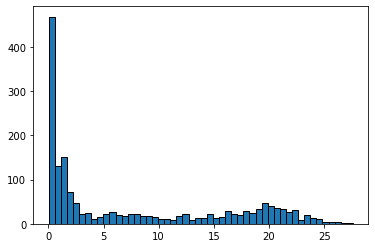

87


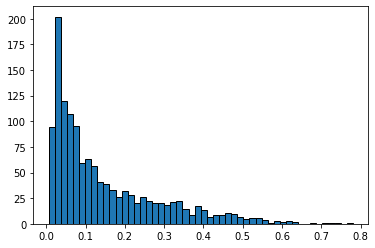

88


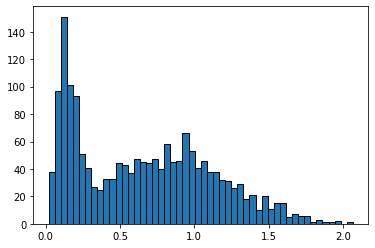

89


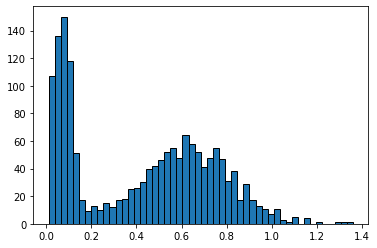

90


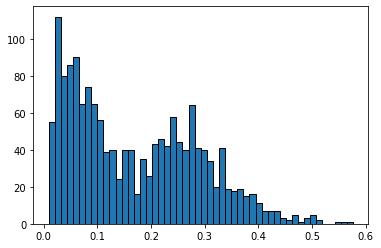

91


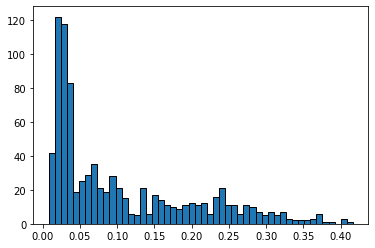

92


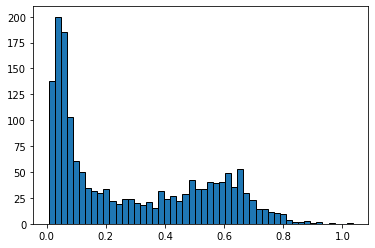

93


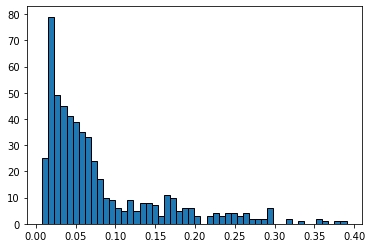

94


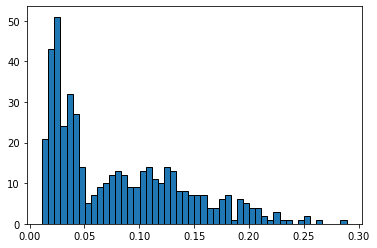

95


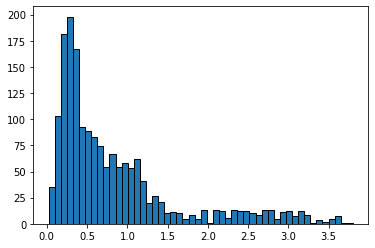

96


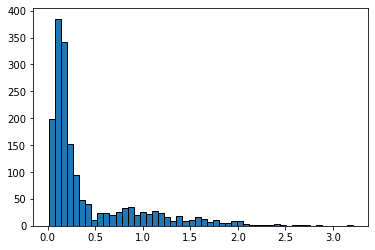

97


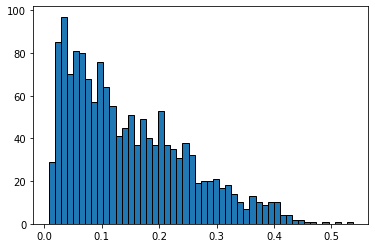

98


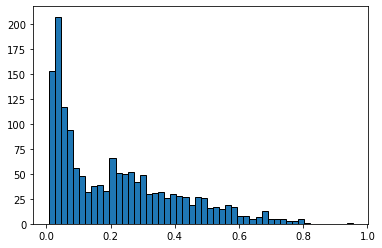

99


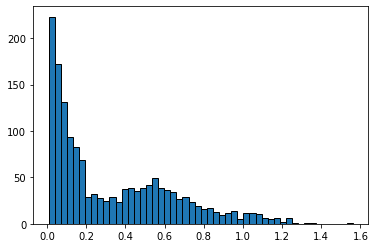

100


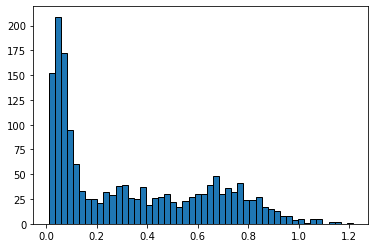

101


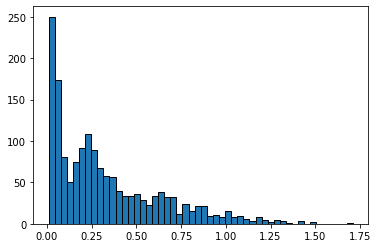

102


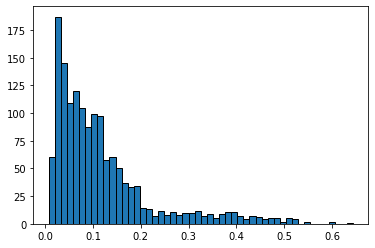

103


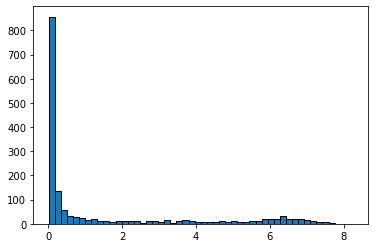

104


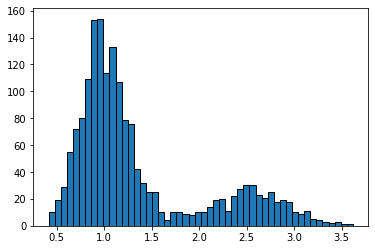

105


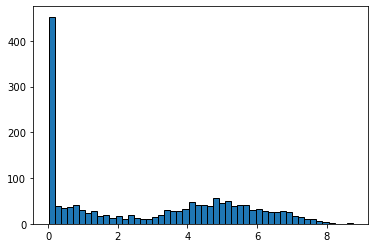

106


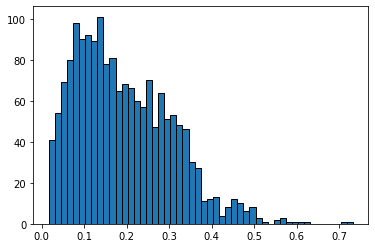

107


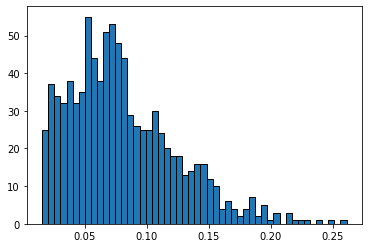

108


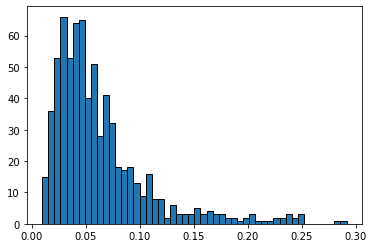

109


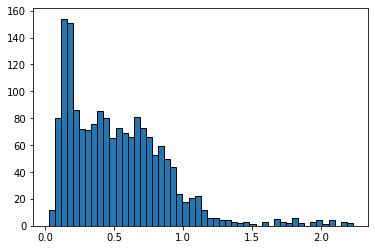

110


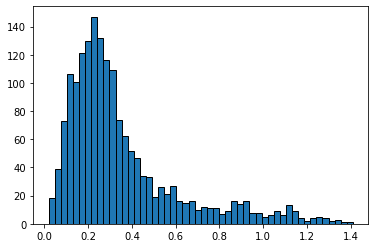

111


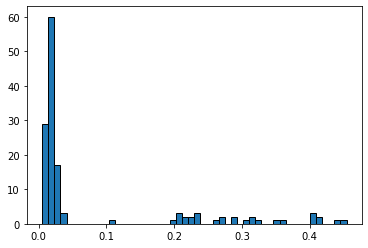

112


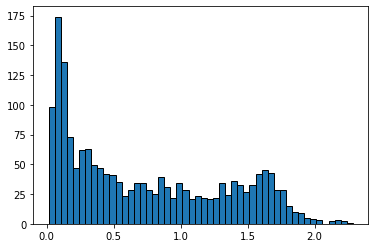

113


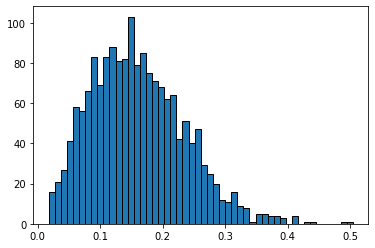

114


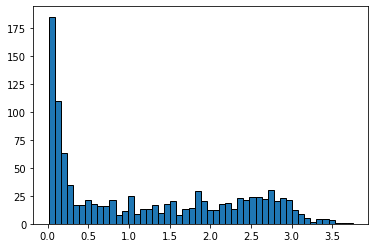

115


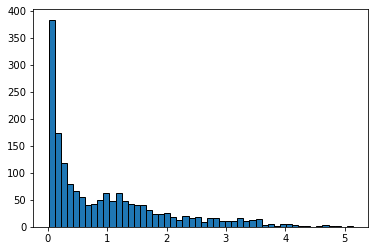

116


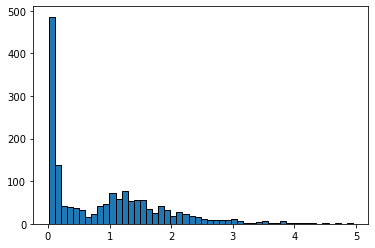

117


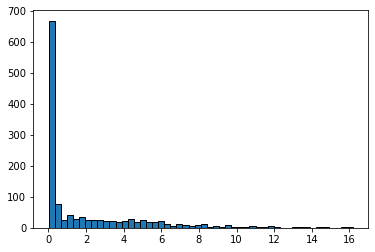

118


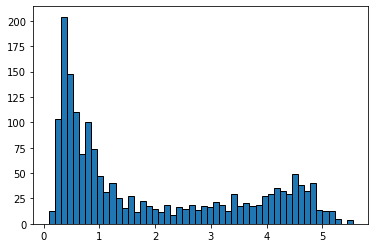

119


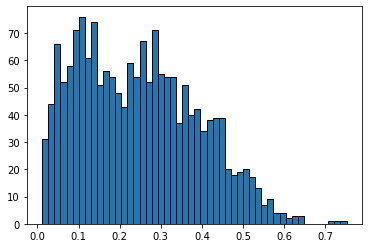

120


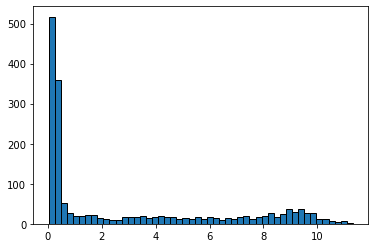

121


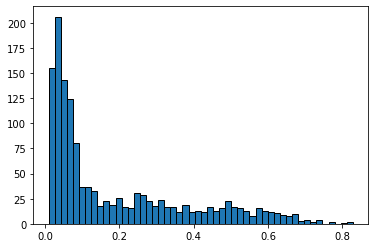

122


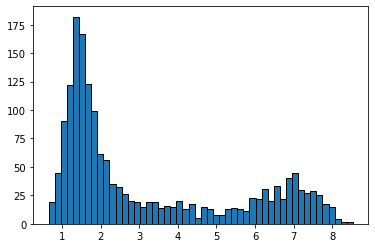

123


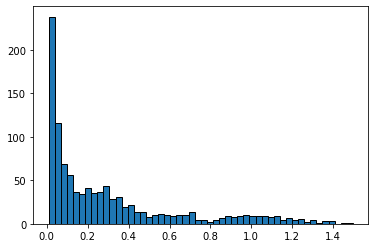

124


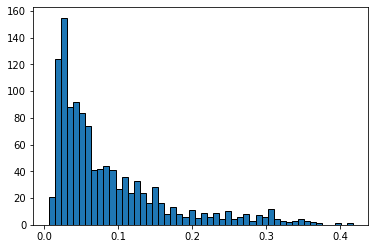

125


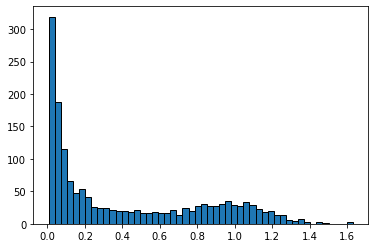

126


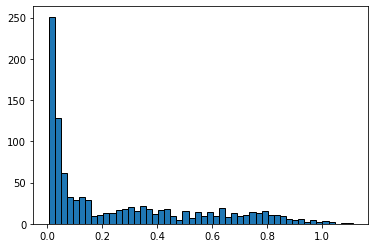

127


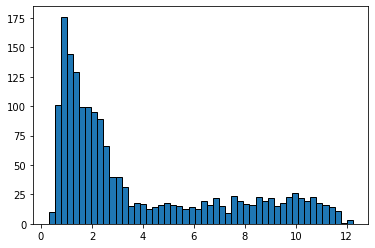

128


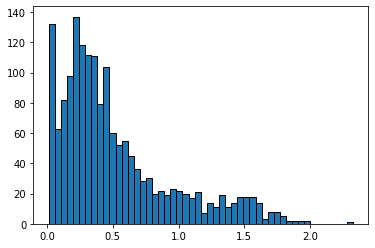

129


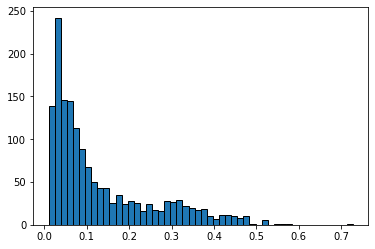

130


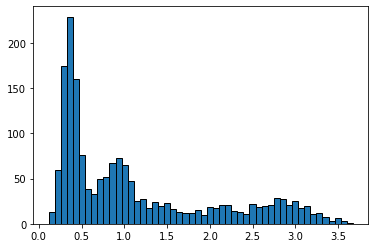

131


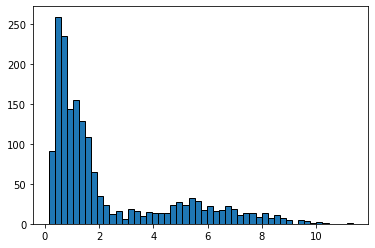

132


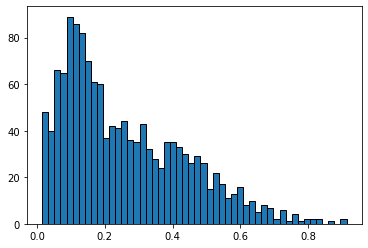

133


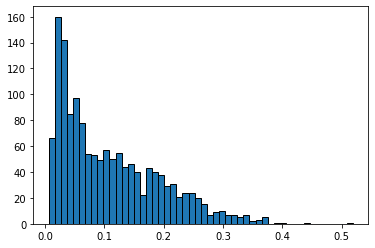

134


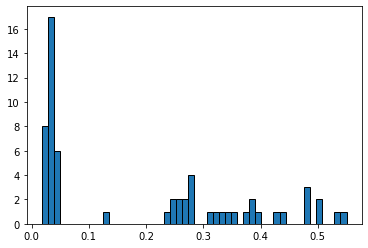

135


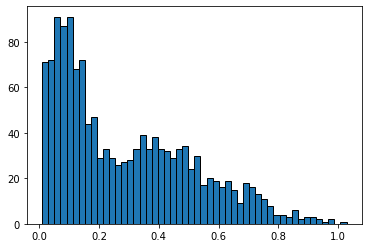

136


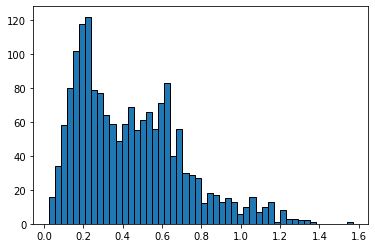

137


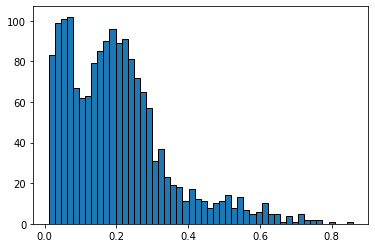

138


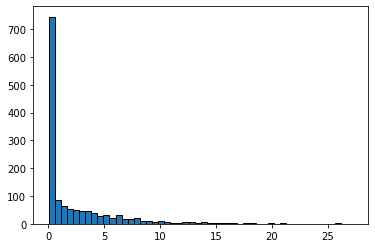

139


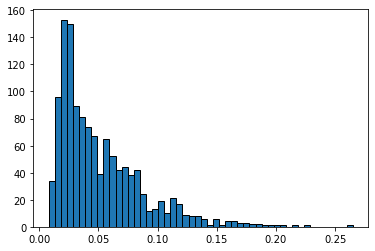

140


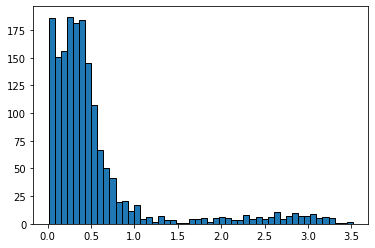

141


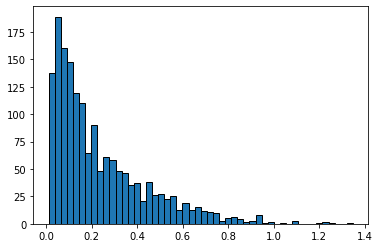

142


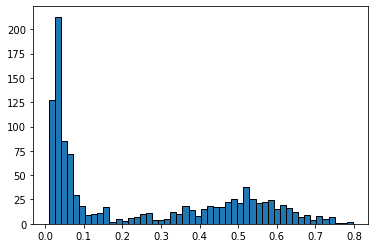

143


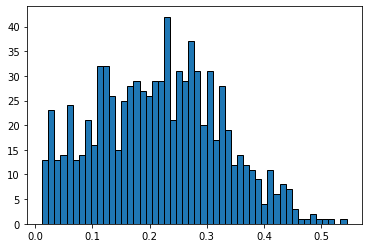

144


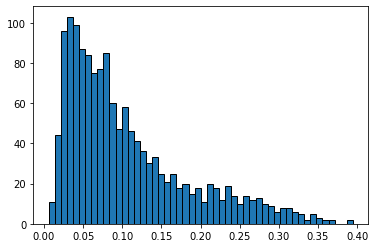

145


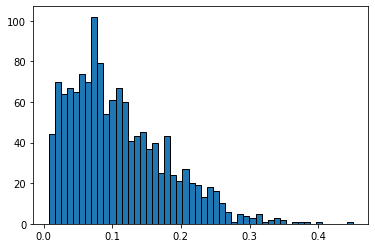

146


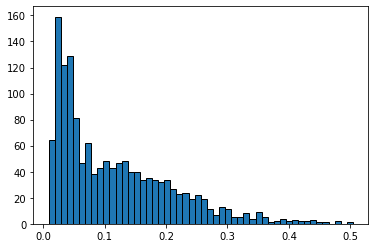

147


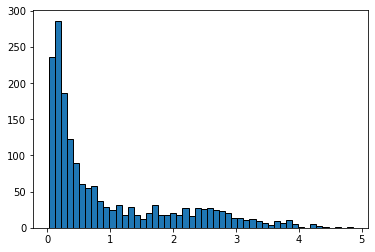

148


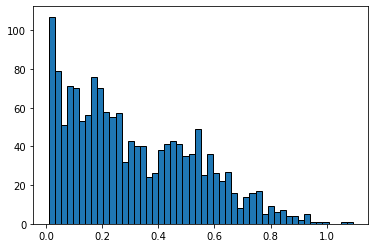

149


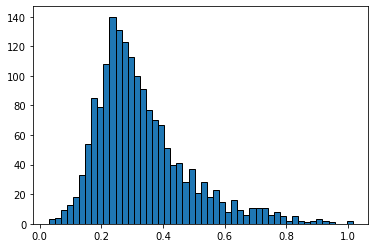

150


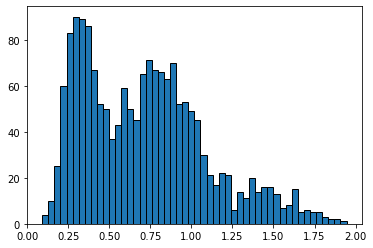

151


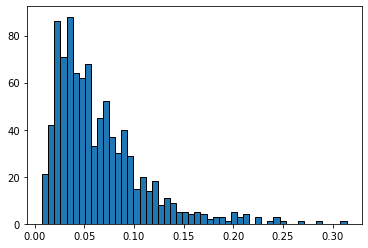

152


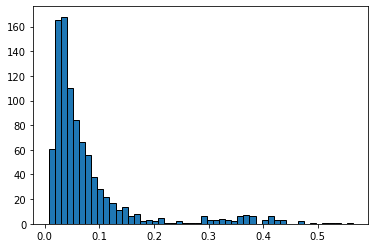

153


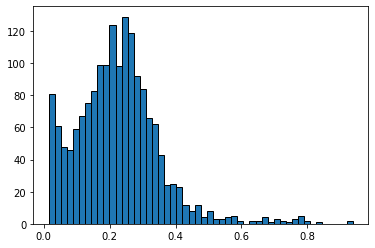

154


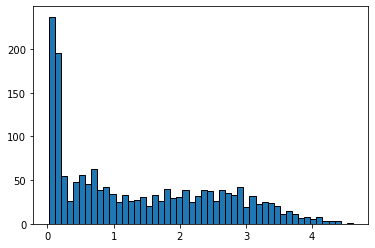

155


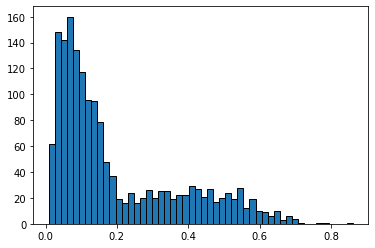

156


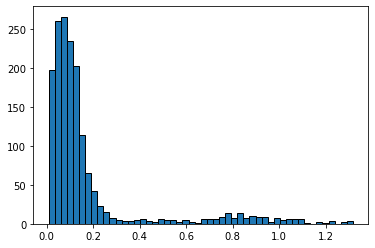

157


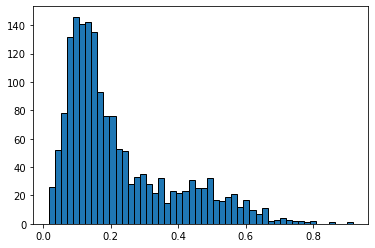

158


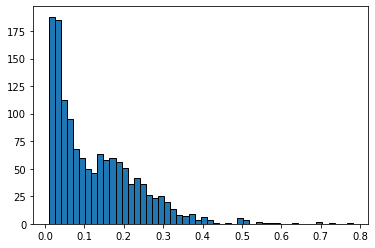

159


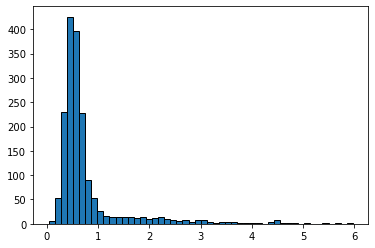

160


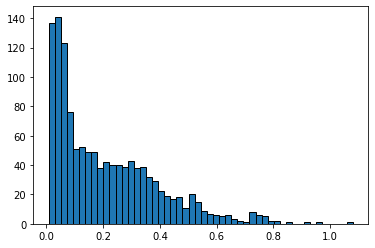

161


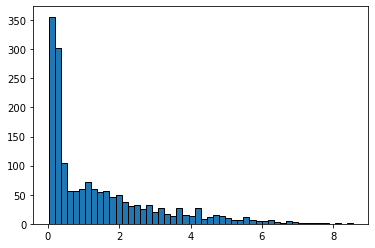

162


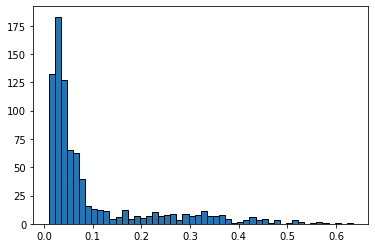

163


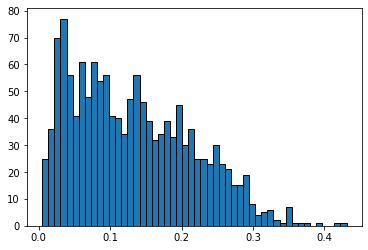

164


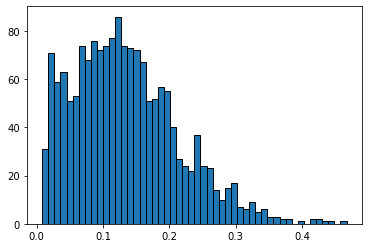

165


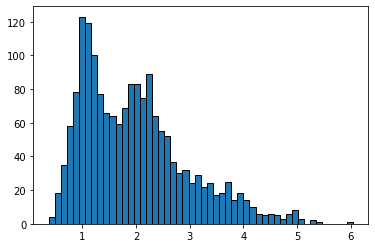

166


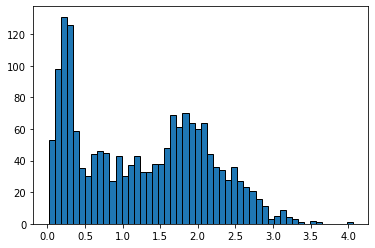

167


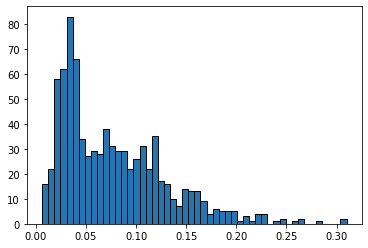

168


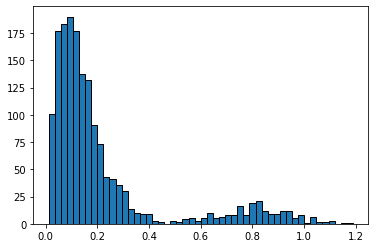

169


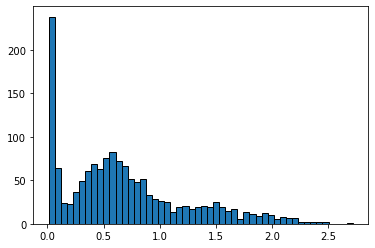

170


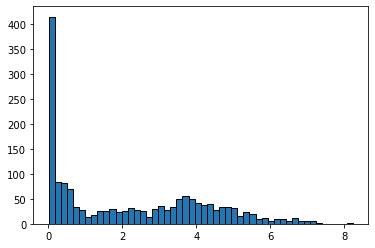

171


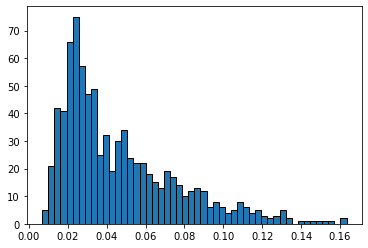

172


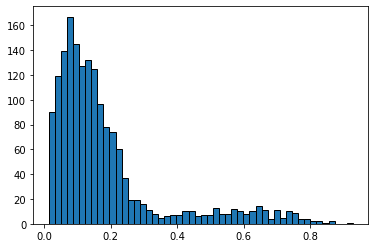

173


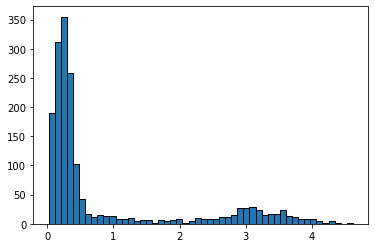

174


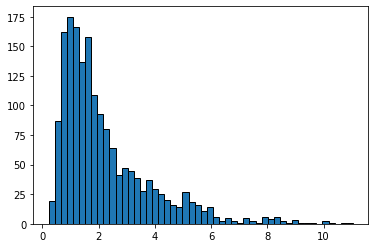

175


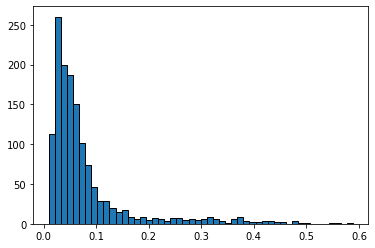

176


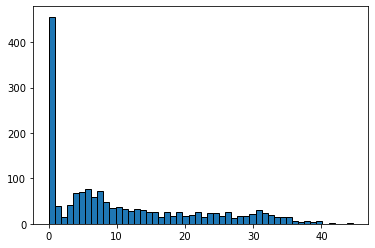

177


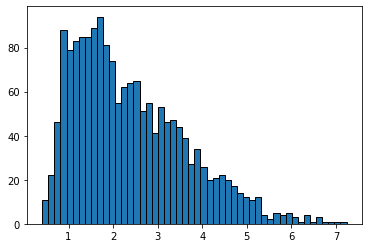

178


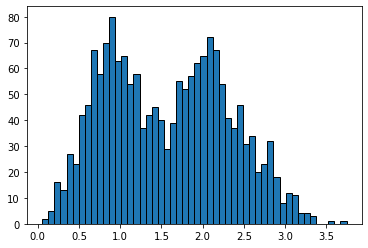

179


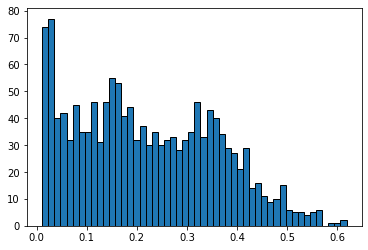

180


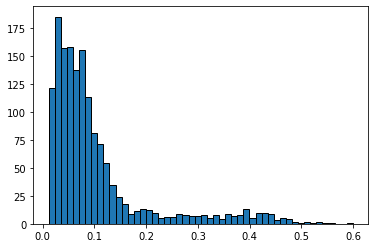

181


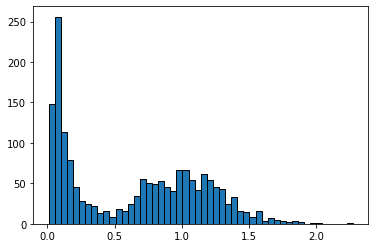

182


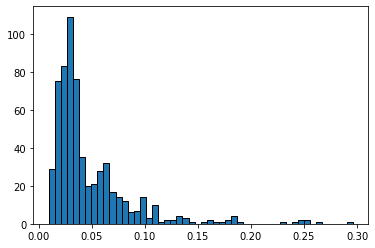

183


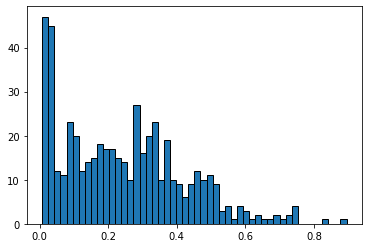

184


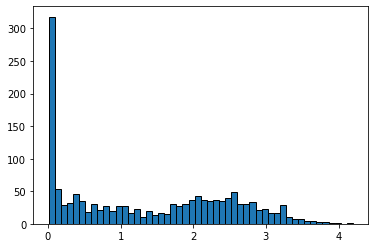

185


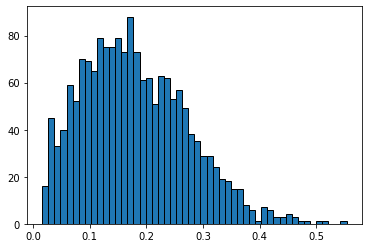

186


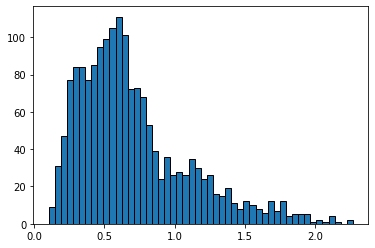

187


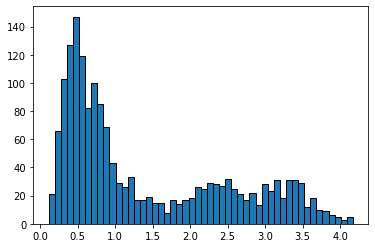

188


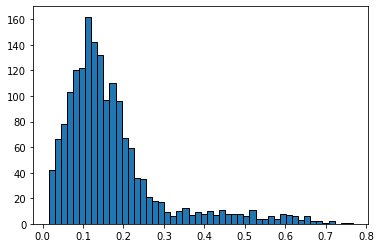

189


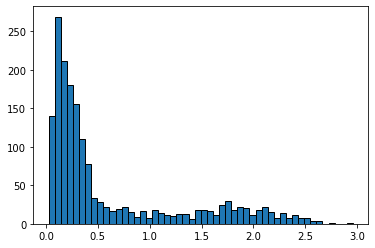

190


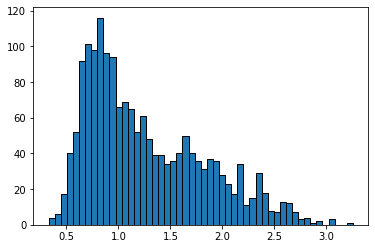

191


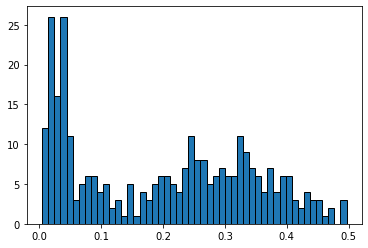

192


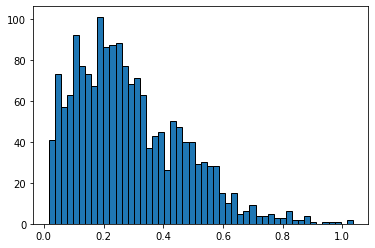

193


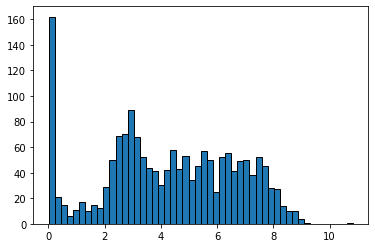

194


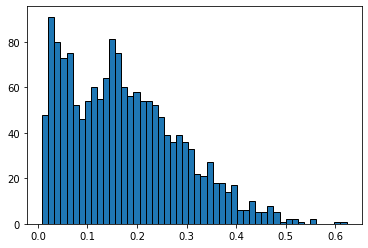

195


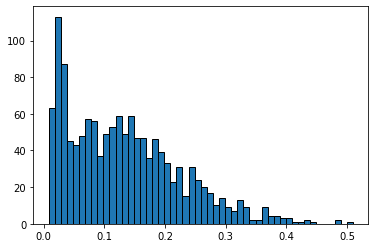

196


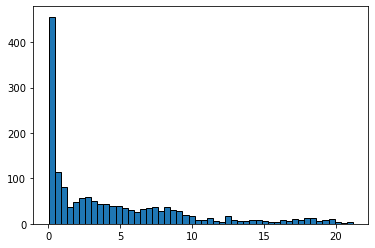

197


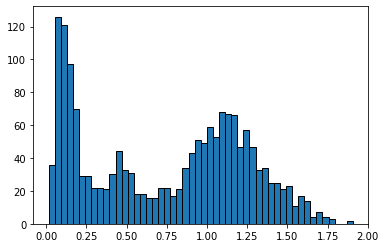

198


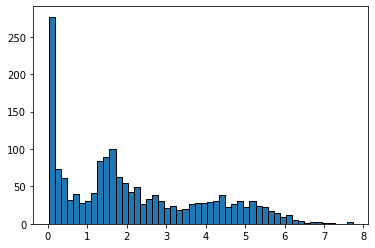

199


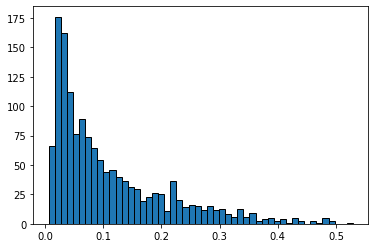

200


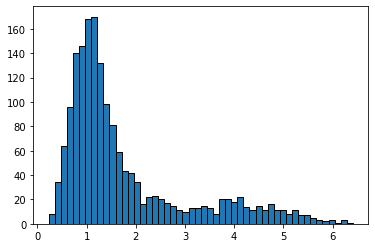

201


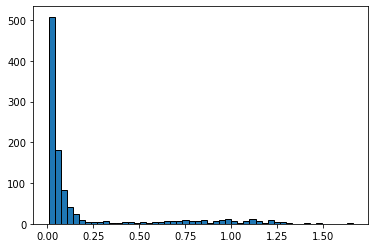

202


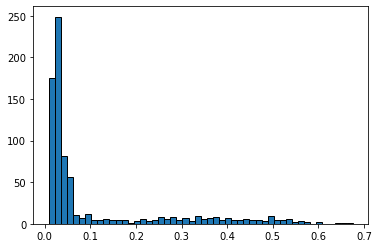

203


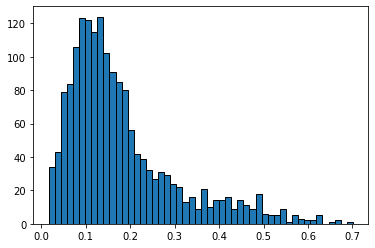

204


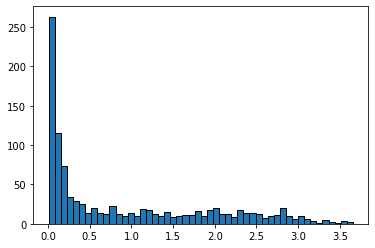

205


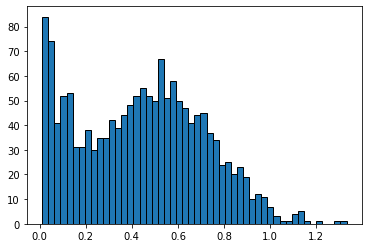

206


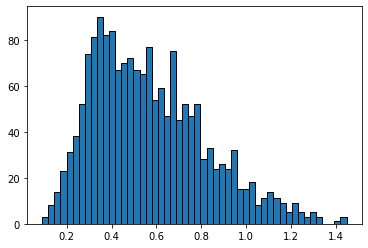

207


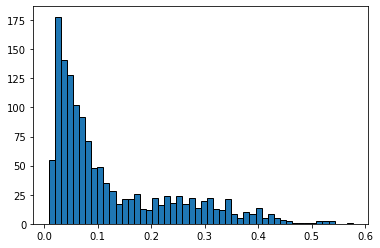

208


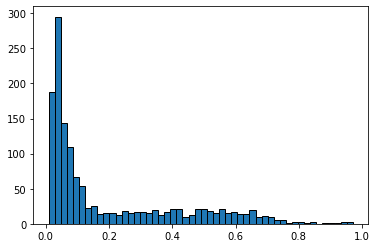

209


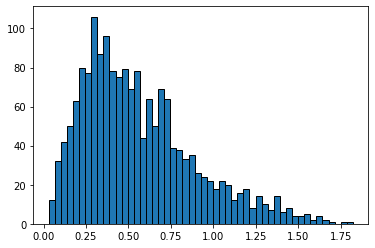

210


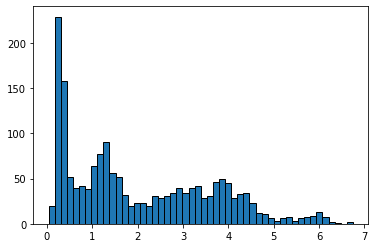

211


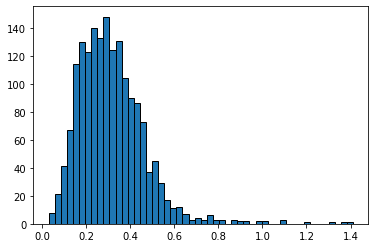

212


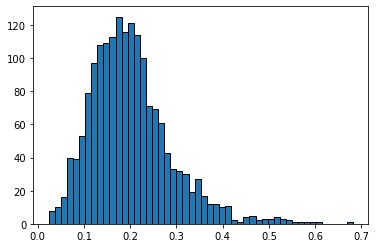

213


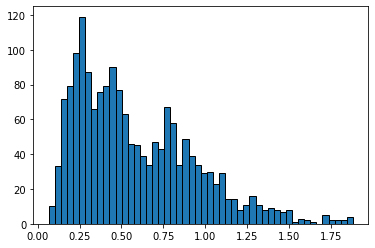

214


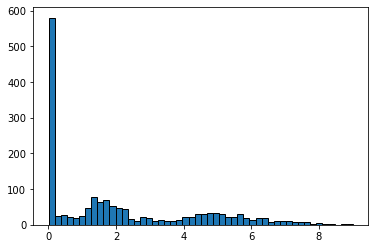

215


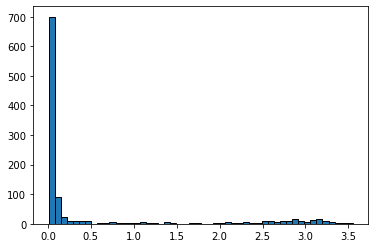

216


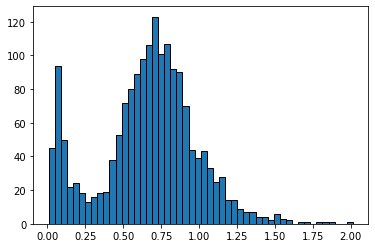

217


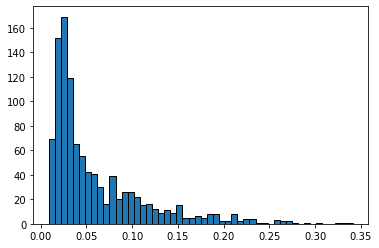

218


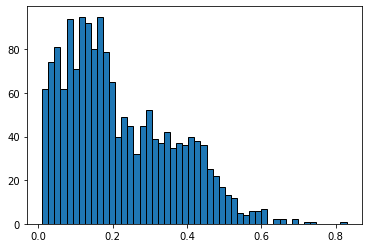

219


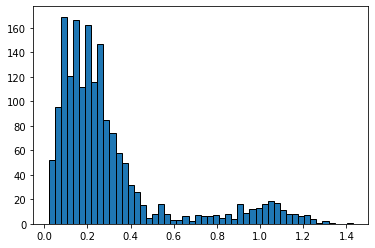

220


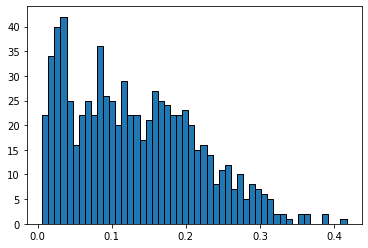

221


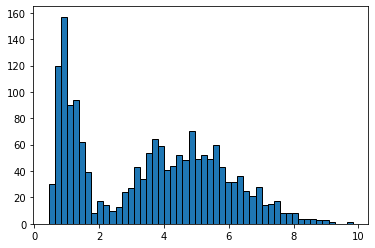

222


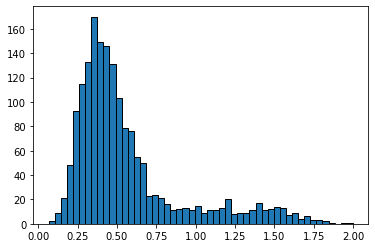

223


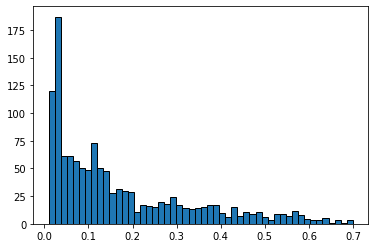

224


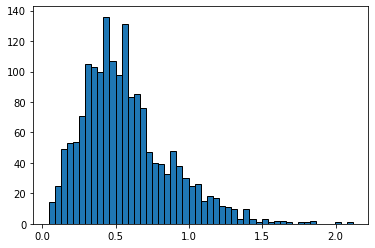

225


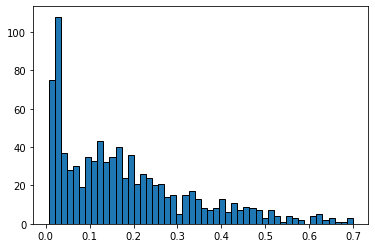

226


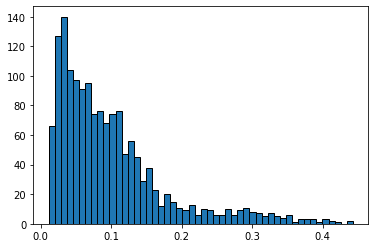

227


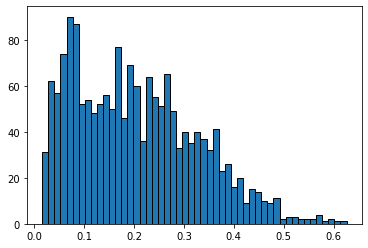

228


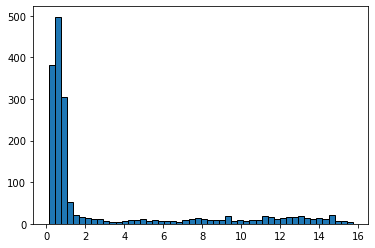

229


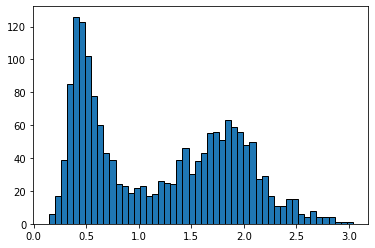

230


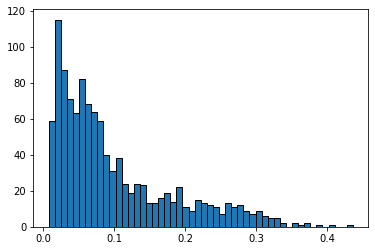

231


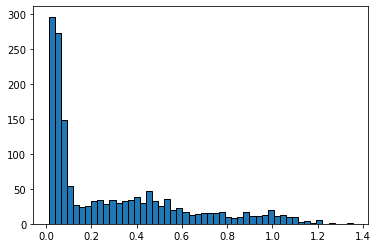

232


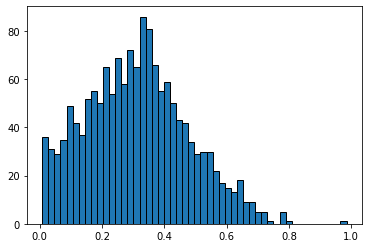

233


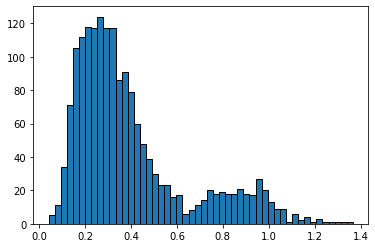

234


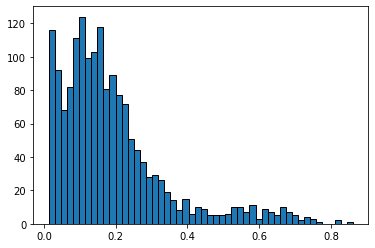

235


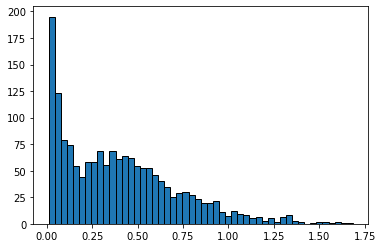

236


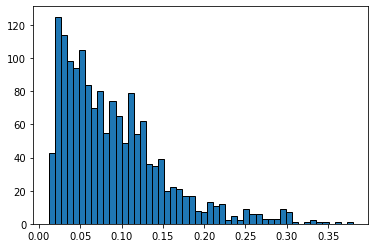

237


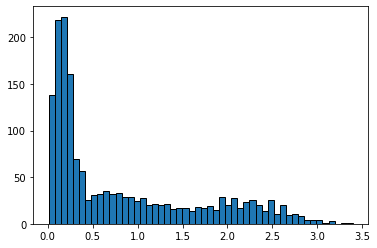

238


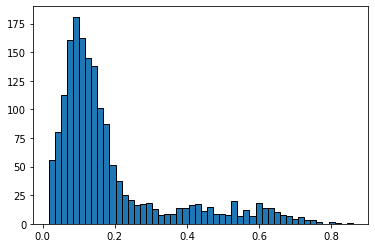

239


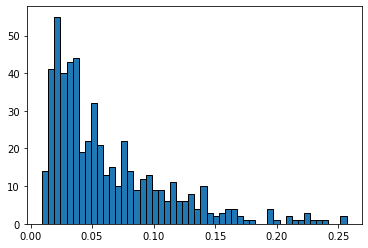

240


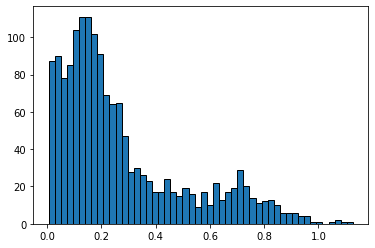

241


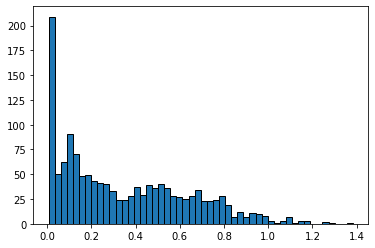

242


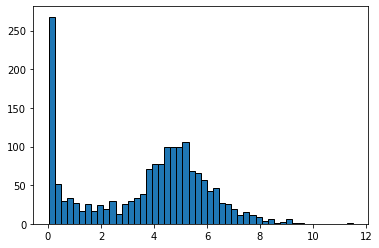

243


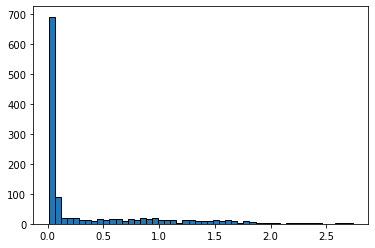

244


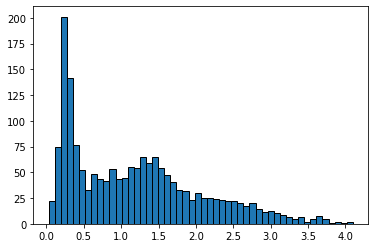

245


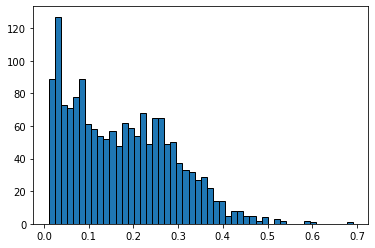

246


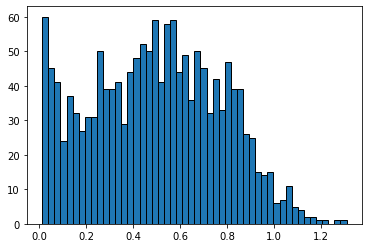

247


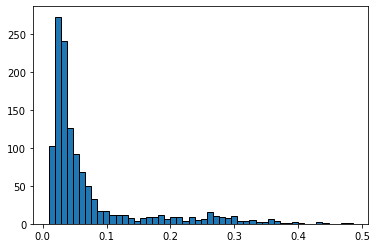

248


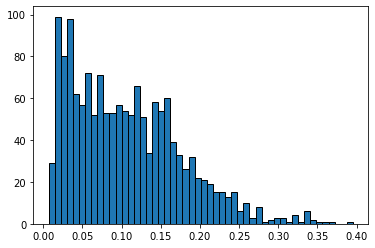

249


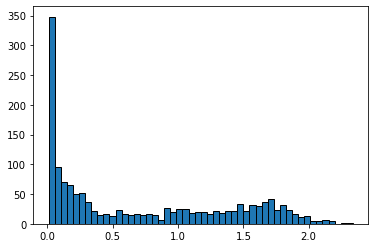

250


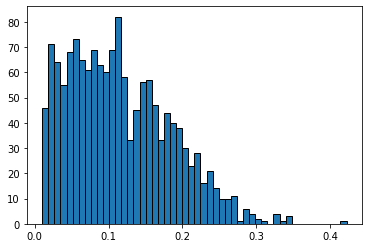

251


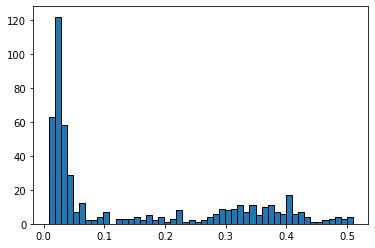

252


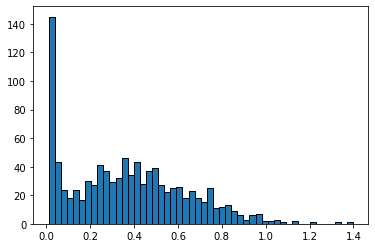

253


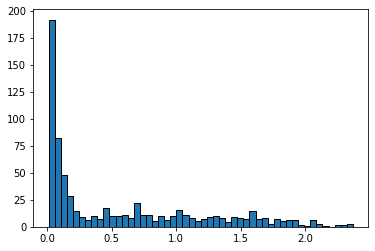

254


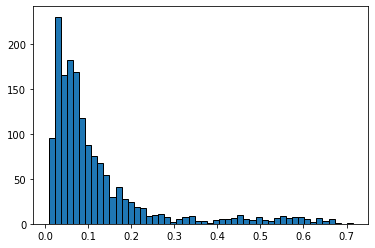

255


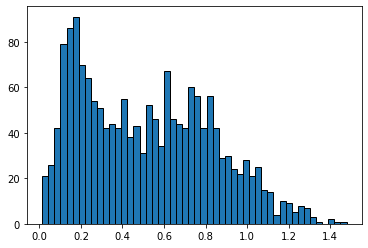

256


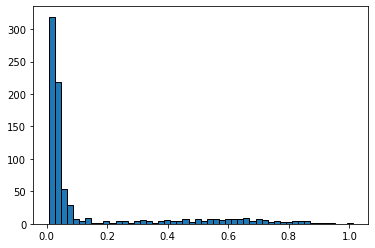

257


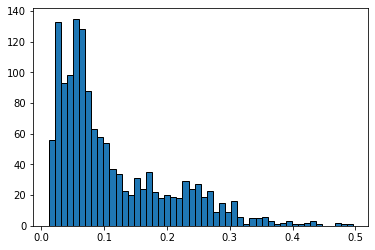

258


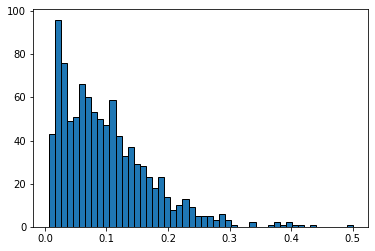

259


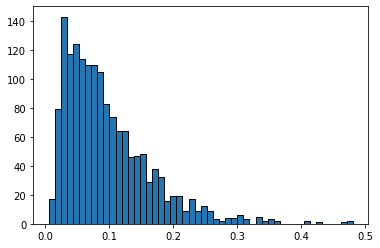

260


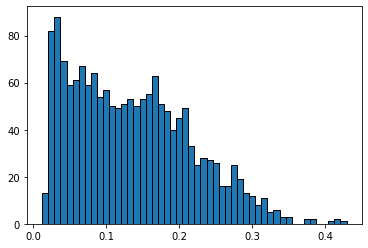

261


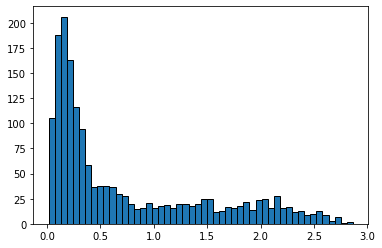

262


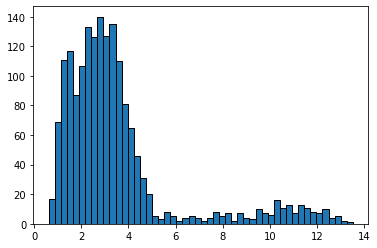

263


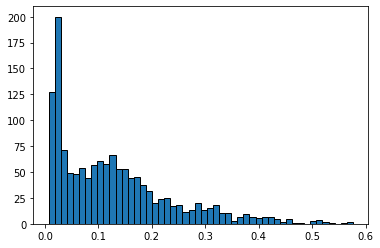

264


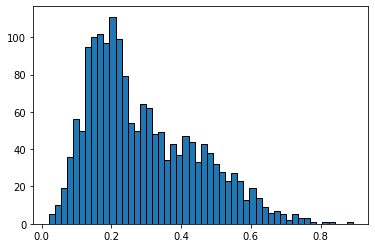

265


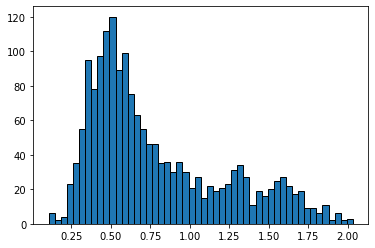

266


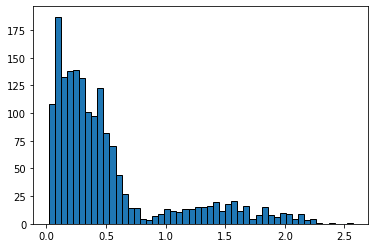

267


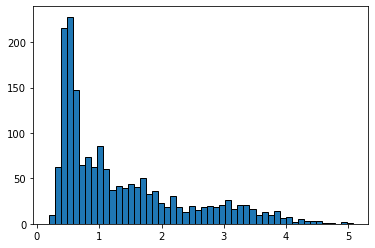

268


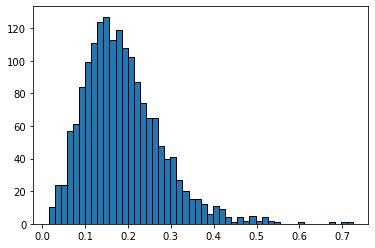

269


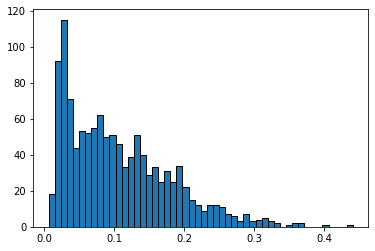

270


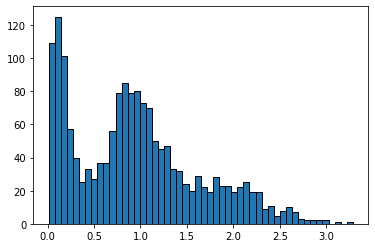

271


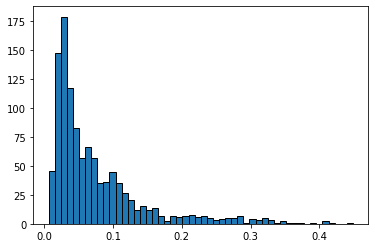

272


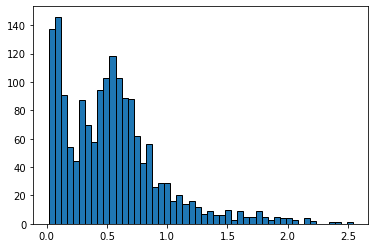

273


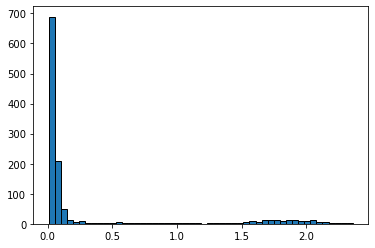

274


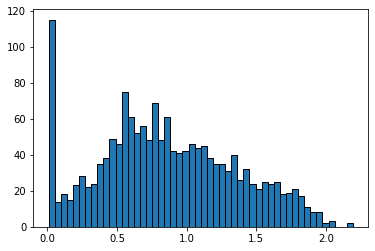

275


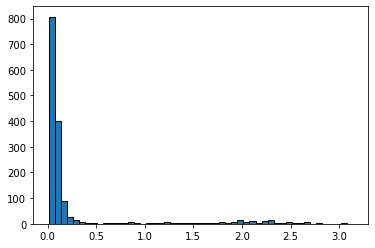

276


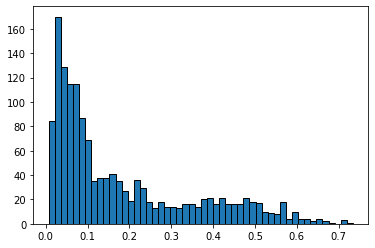

277


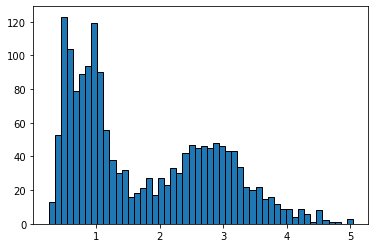

278


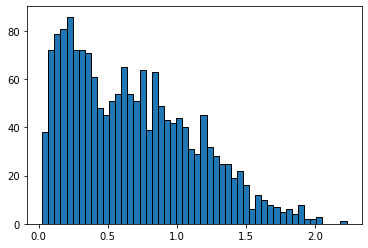

279


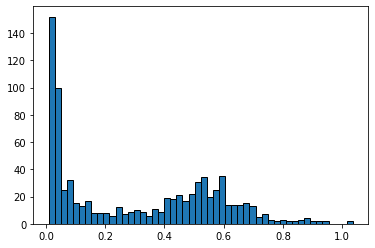

280


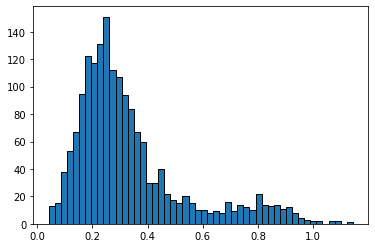

281


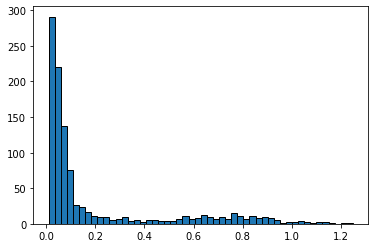

282


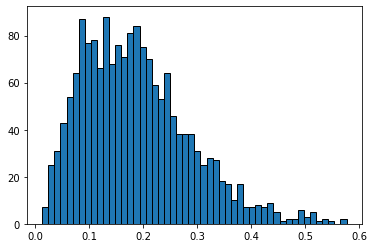

283


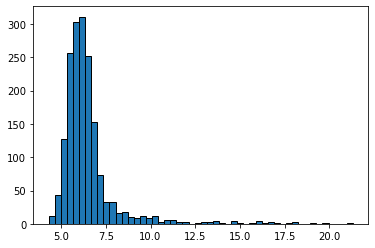

284


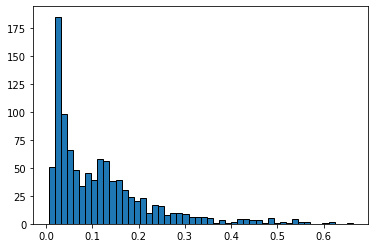

285


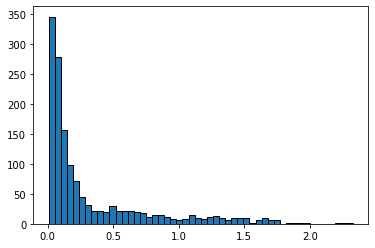

286


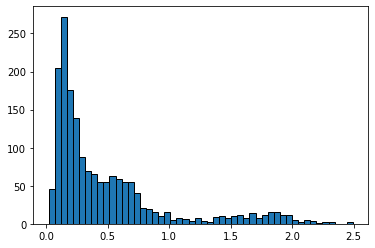

287


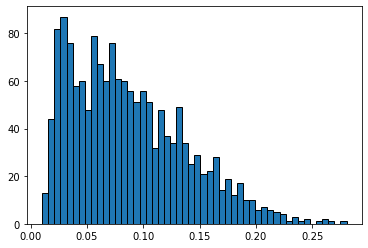

288


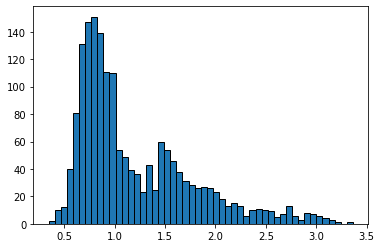

289


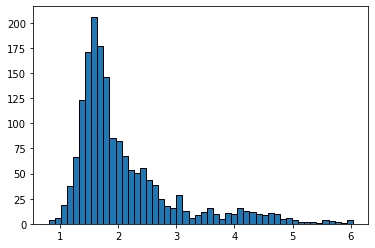

290


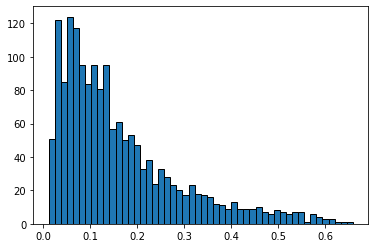

291


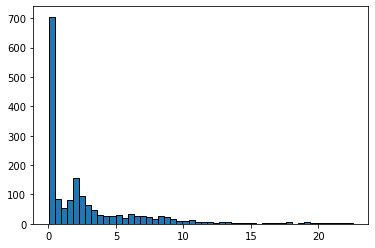

292


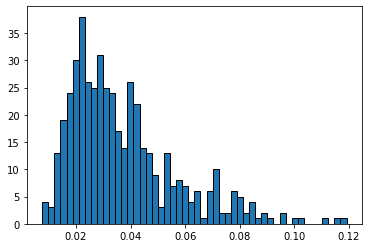

293


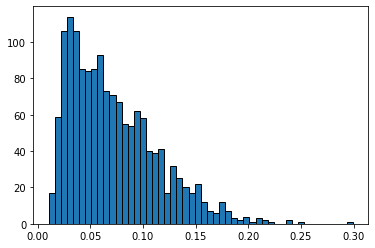

294


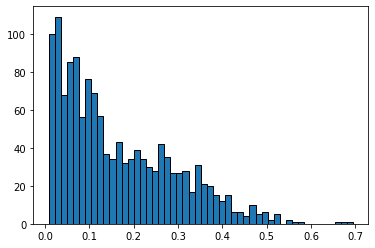

295


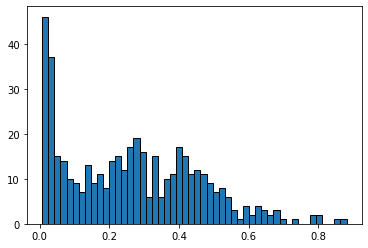

296


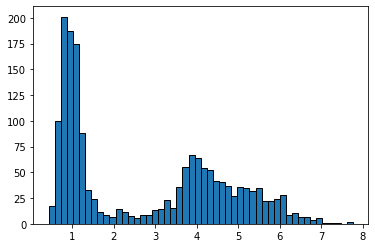

297


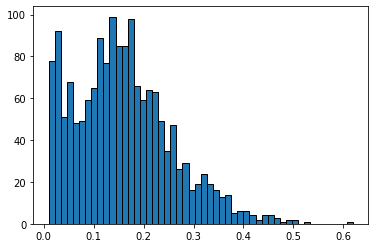

298


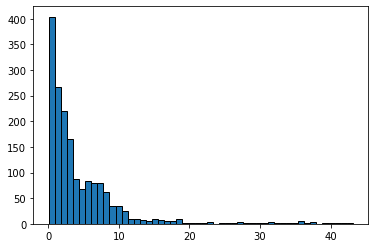

299


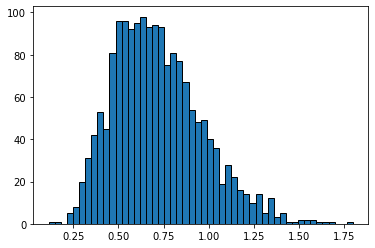

300


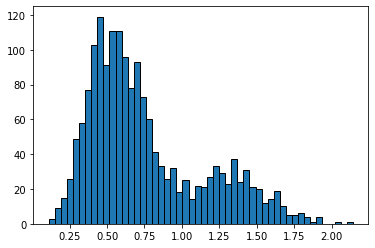

301


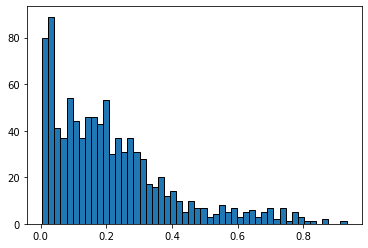

302


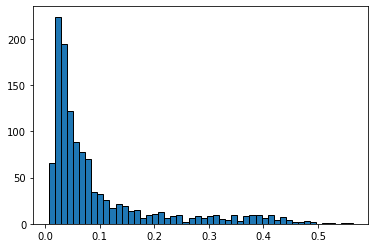

303


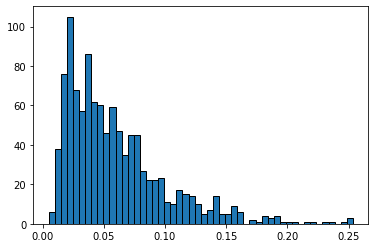

304


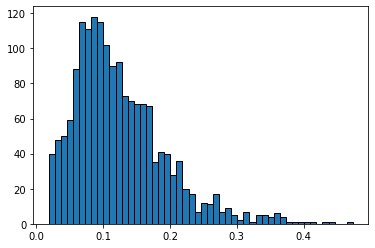

305


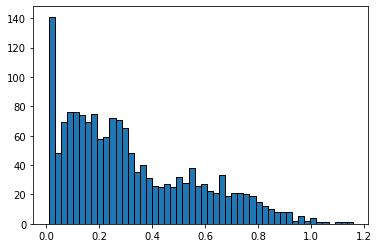

306


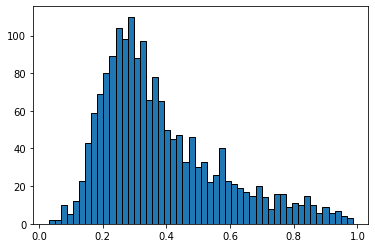

307


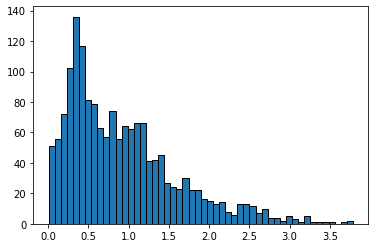

308


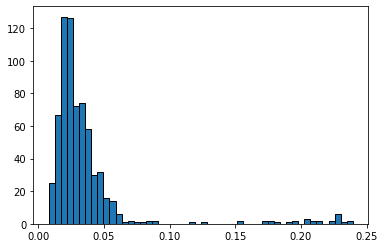

309


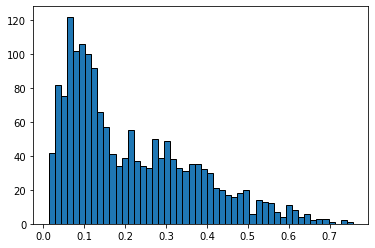

310


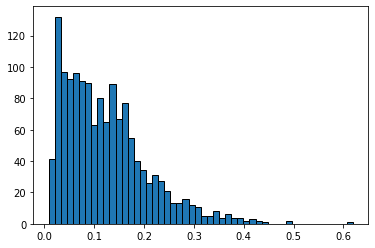

311


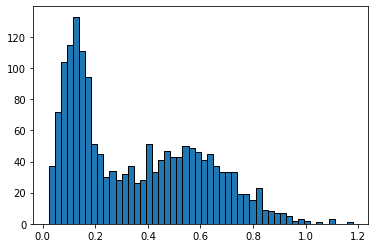

312


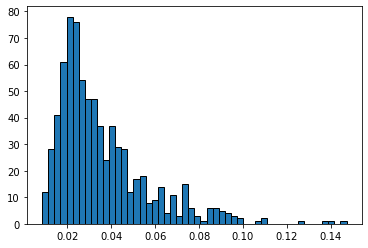

313


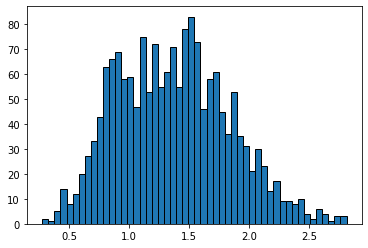

314


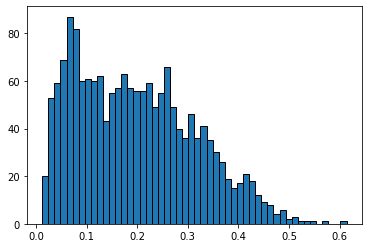

315


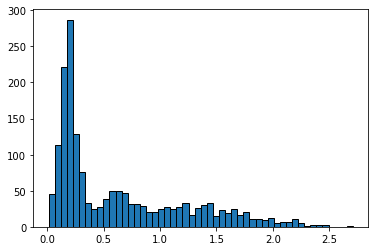

316


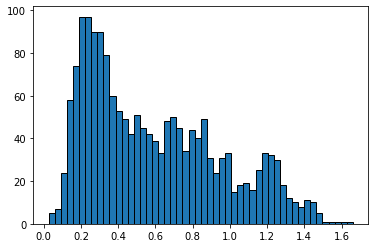

317


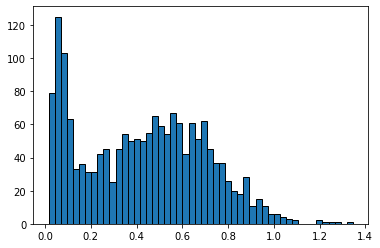

318


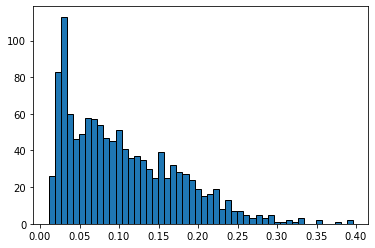

319


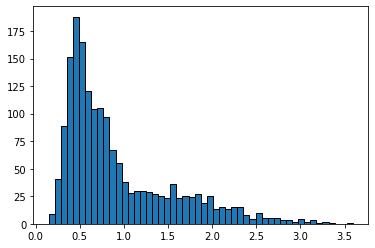

320


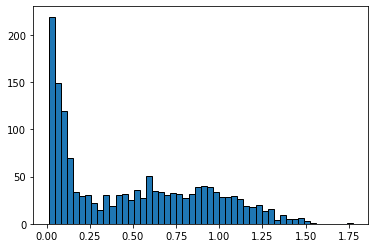

321


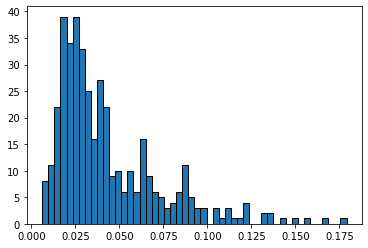

322


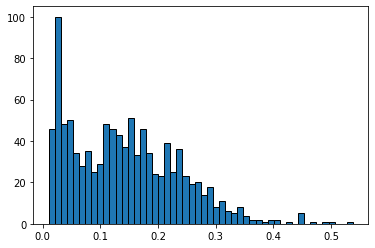

323


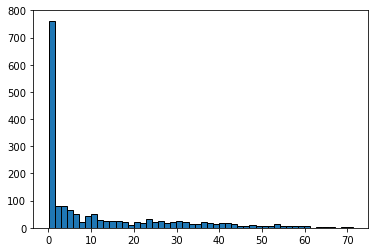

324


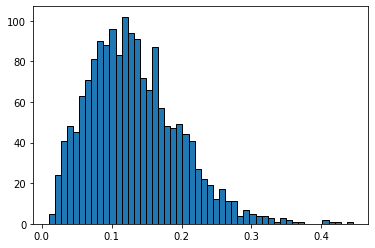

325


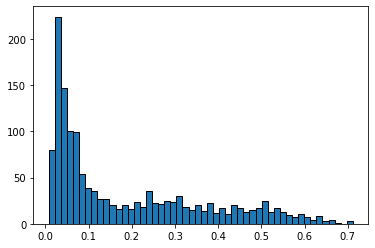

326


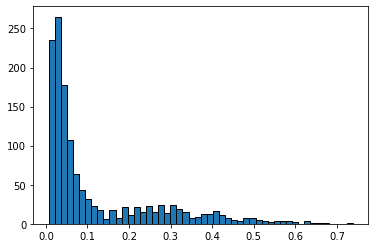

327


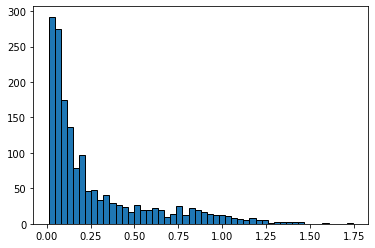

328


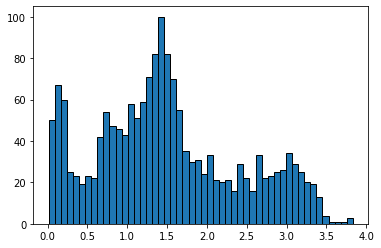

329


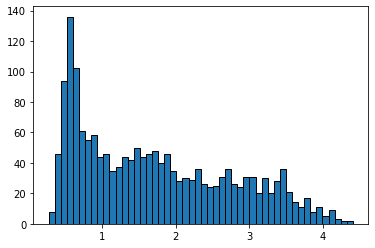

330


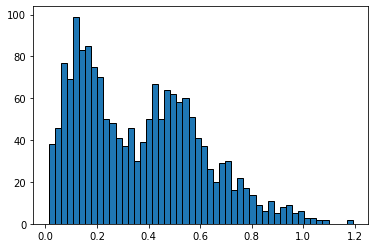

331


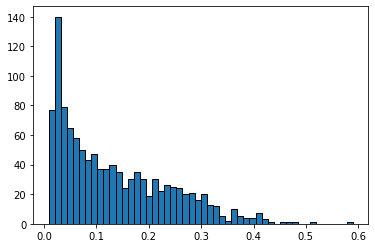

332


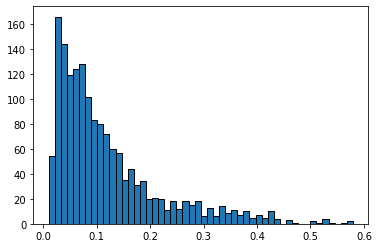

333


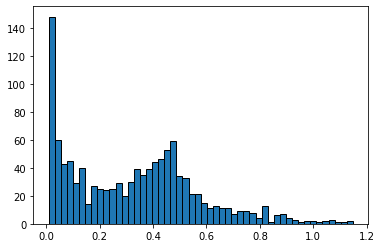

334


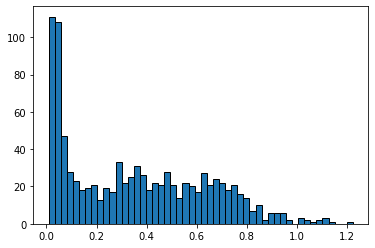

335


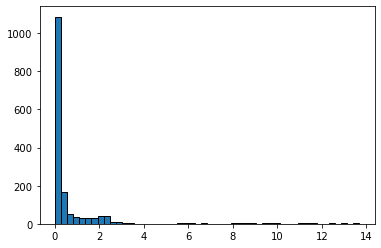

336


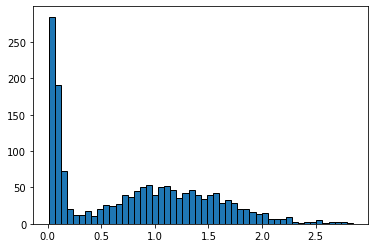

337


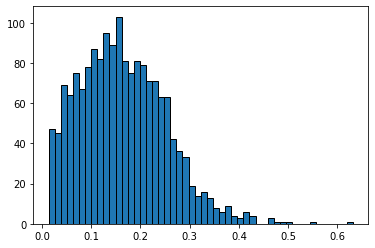

338


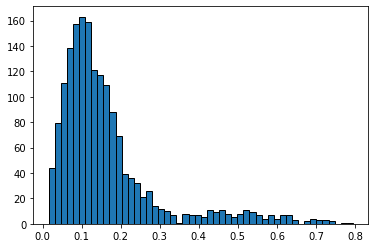

339


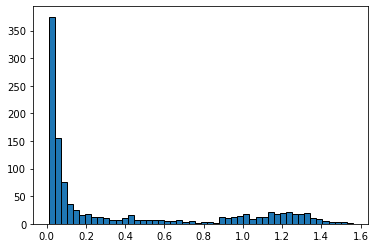

340


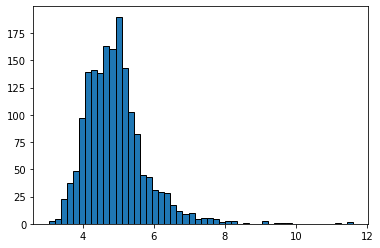

341


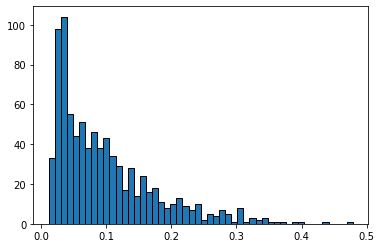

342


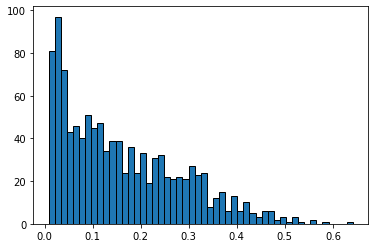

343


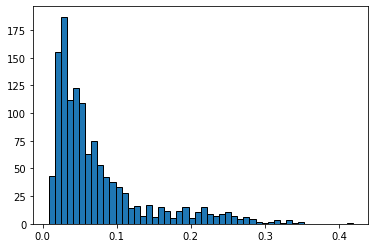

344


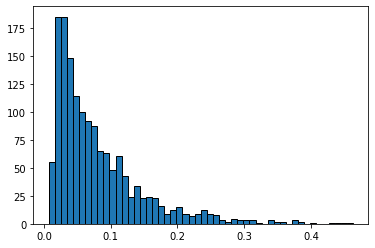

345


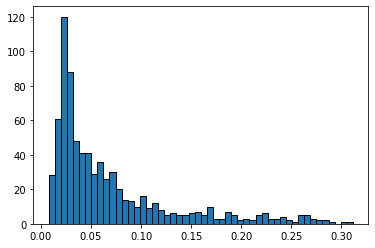

346


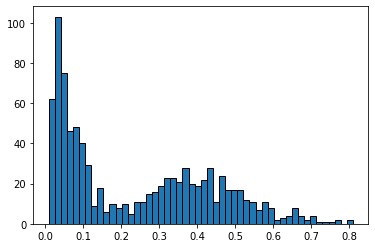

347


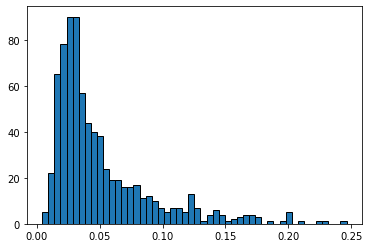

348


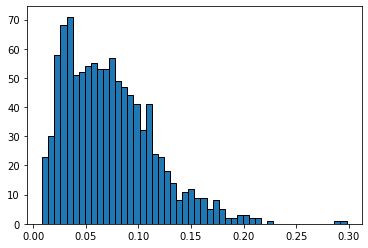

349


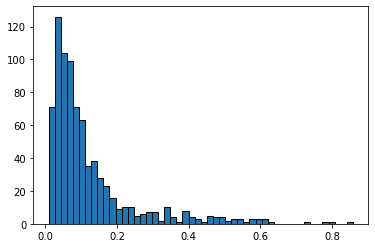

350


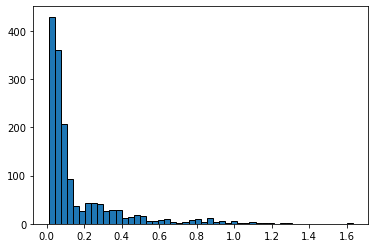

351


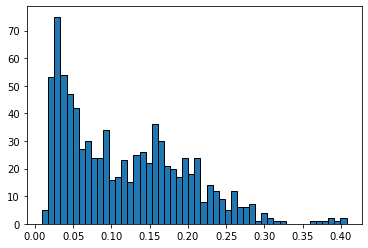

352


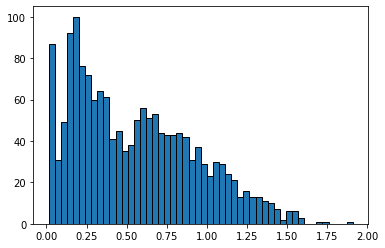

353


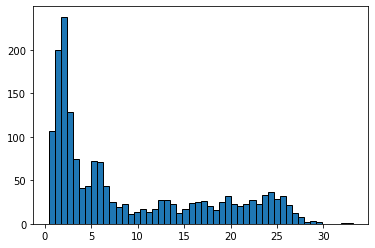

354


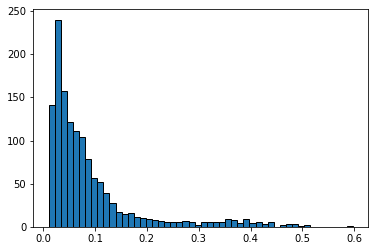

355


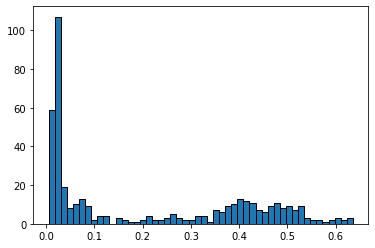

356


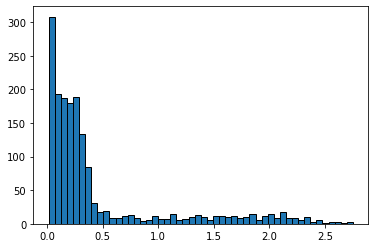

357


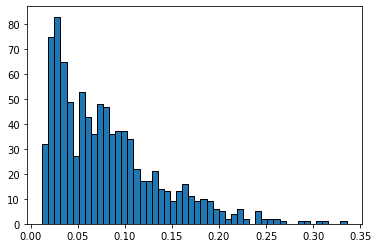

358


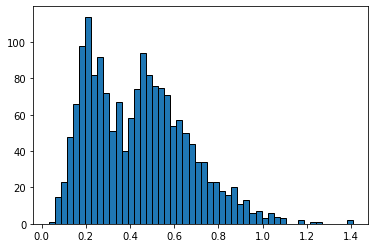

359


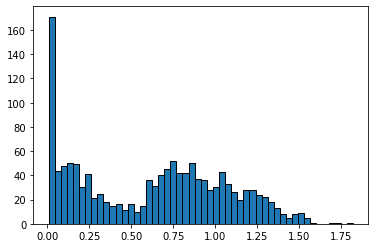

360


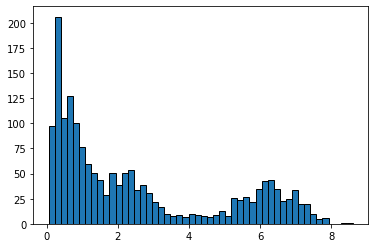

361


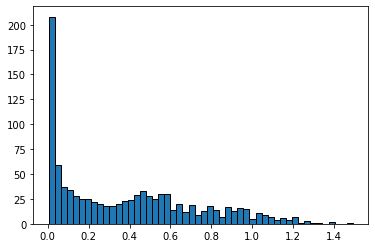

362


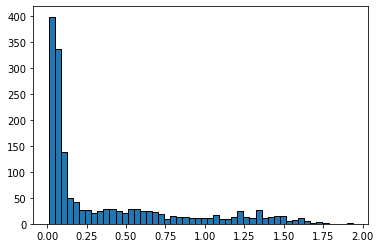

363


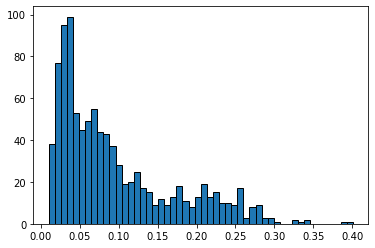

364


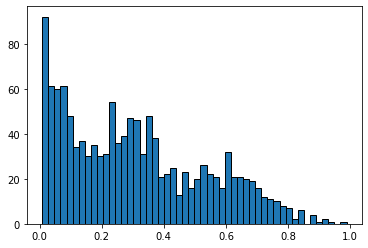

365


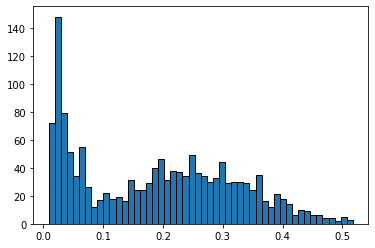

366


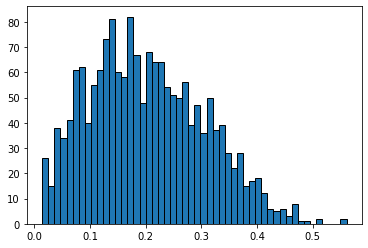

367


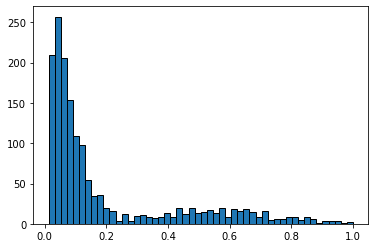

368


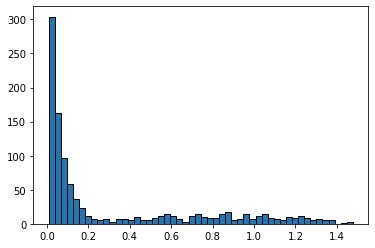

369


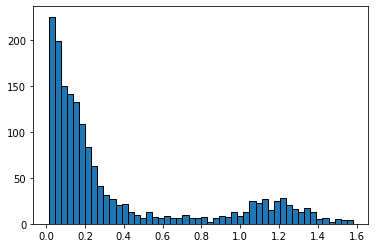

370


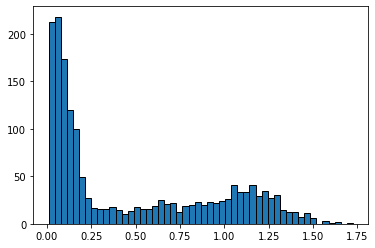

371


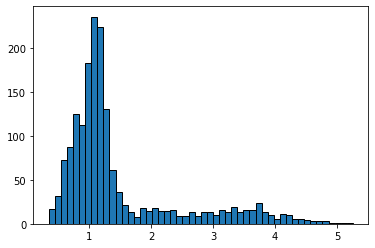

372


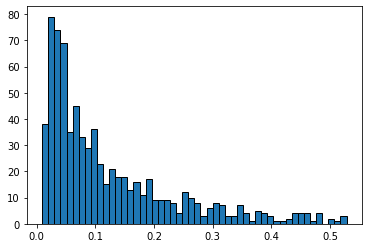

373


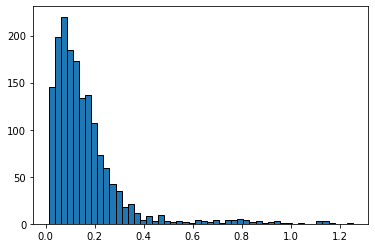

374


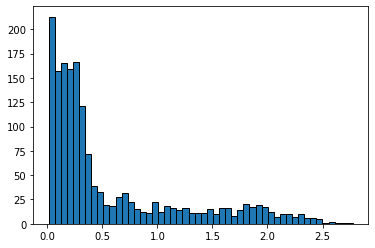

KeyboardInterrupt: 

In [11]:
X0_ori=adata.layers['Ms']
X0_bin=X0_ori.copy()
EG_bin_genes_center=[]
EG_bin_genes=[]
for i in range(X0_ori.shape[1]):
    print(i)

    
    mask=X0_ori[:,i]>0
    plt.hist(X0_ori[:,i][mask],bins=50,edgecolor='k')
    plt.show()
    
    x=X0_ori[:,i]
    split_x=best_split(x)

    kmeans = KMeans(n_clusters=2, random_state=0).fit(X0_ori[:,i][:,None])
    klabels=kmeans.labels_
    kcenters = np.sort(np.array([i[0] for i in kmeans.cluster_centers_]))
    cl_score=silhouette_score(X0_ori[:,i][:,None], klabels, metric="euclidean")

    bin_flag=0        
    if len(split_x)>0 and cl_score>0.65:
        for si in range(len(split_x)):
            if kcenters[0]<split_x[si] and kcenters[1]>split_x[si]:
                bin_flag=1

                break
    if bin_flag==1:
        
        EG_bin_genes.append(gene_arr[i])

        EG_bin_genes_center.append([kcenters[0],kcenters[1]])

            
        

In [15]:
EG_bin_genes_center=np.array(EG_bin_genes_center)
EG_bin_genes=np.array(EG_bin_genes)
np.save(result_path+'EG_bin_genes.npy',EG_bin_genes)
np.save(result_path+'EG_bin_genes_center.npy',EG_bin_genes_center)

In [16]:
print(len(EG_bin_genes),len(np.unique(EG_bin_genes)))

470 470


In [17]:
adata=adata0[:,EG_bin_genes]

scv.pp.filter_and_normalize(adata,min_shared_counts=10)#min_shared_cells=150,,n_top_genes=1000#, 
print(adata.X.shape)
scv.pp.neighbors(adata, n_neighbors=20)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=20)
scv.tl.umap(adata)
scv.tl.velocity(adata,mode='stochastic',perc=[5, 95])

scv.tl.velocity_graph(adata,xkey='Ms')

Trying to set attribute `.obs` of view, copying.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
(1731, 470)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


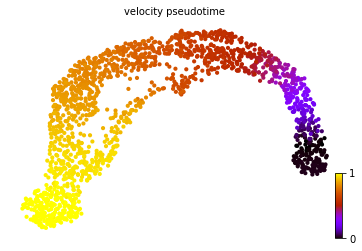

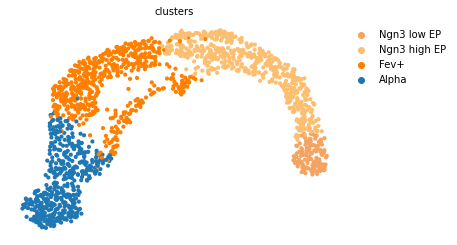

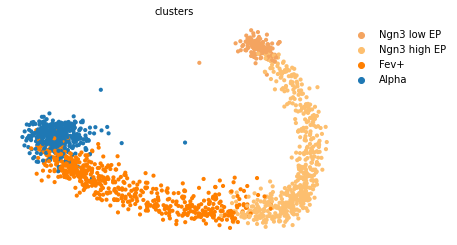

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


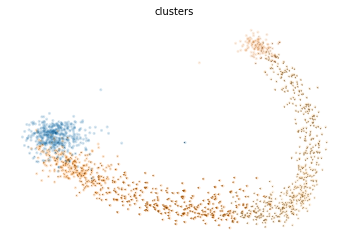

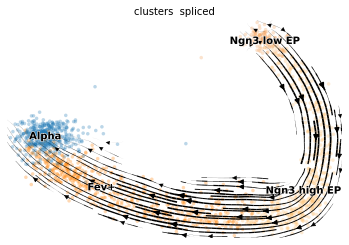

In [18]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, basis='umap',color='velocity_pseudotime', color_map='gnuplot')
# scv.tl.latent_time(adata)
# scv.pl.scatter(adata, basis='pca',color='latent_time', color_map='jet', size=80)
scv.pl.scatter(adata, basis='umap',color='clusters')
scv.pl.scatter(adata, basis='pca',color='clusters')
scv.pl.velocity_embedding(adata, basis='pca',color='clusters')

scv.pl.velocity_embedding_stream(adata, basis='pca',color='clusters',s=50,layer='spliced',color_map='jet')

saving figure to file ./figures/scvelo_EG_vgraph.png


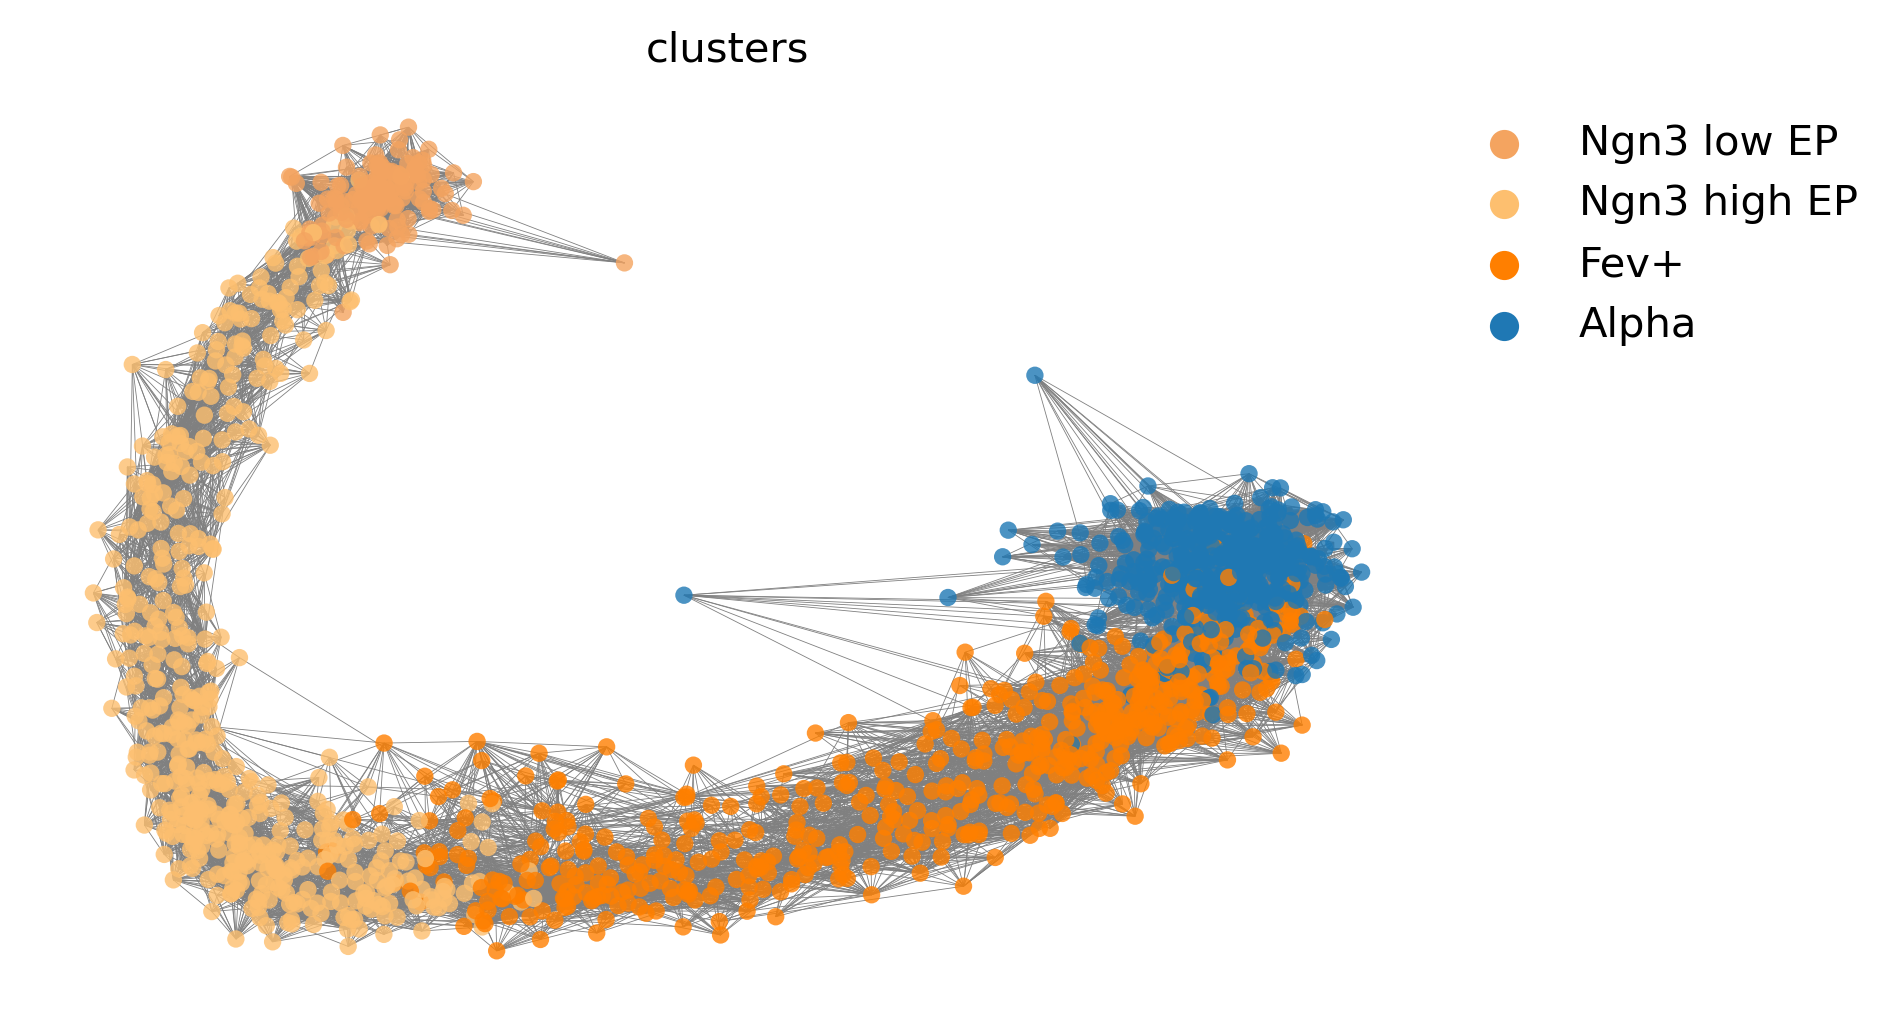

In [19]:
adata.obsm['X_pca'][:,0]=-adata.obsm['X_pca'][:,0]
scv.pl.velocity_graph(adata, basis='pca',color='clusters',dpi=300,save='EG_vgraph.png')

In [20]:
adata.write_h5ad(result_path+'EG_bin.h5ad')#h5ad save all features

In [21]:
adata0_sel=adata0[:,EG_bin_genes]
adata0_sel.write_h5ad(result_path+'EG_ori_bin.h5ad')
adata0_sel

View of AnnData object with n_obs × n_vars = 1731 × 470
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'